This notebook is best viewed here: http://nbviewer.jupyter.org 


#### Purpose
    - This notebook runs RDA on the Doug-fir SNP data for interior variety to isolate genotype-environment associations

#### Notebook Outline
    
- __Prepare data__
    - Because RDA requires no missing data, I first use python to isolate interior loci with no missing data.
    - To include more loci, for any population that has missing data at a locus, I impute by taking the average frequency of the four most geographically proximal populations using Vincenty distance.
        
- __Run RDA__
    - I then switch to R to use the package `vegan` to run RDA

#############################################################################################################################
# <center> python
#############################################################################################################################

# prepare data

In [1]:
from pythonimports import *
from vincenty import vincenty
from tqdm import tqdm

lview,dview = get_client()

56 56


In [2]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit 4937ed6baded6e6e058c905e26e9ae16bfe3f0d9
Author: Brandon <lindb@vcu.edu>
Date:   Tue Dec 1 11:28:39 2020 -0700
Today:	December 04, 2020 - 15:45:11
##################################################################



In [12]:
# variables

rdadir = makedir('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda')
# 03-filtered SNP file
snpfile = op.join(op.dirname(rdadir), 'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt')
# centered/standardized environmental data
envfile = '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_std_env-19variables_change-p6.txt'
# loci with no missing data
nomissingfile = op.join(rdadir, op.basename(snpfile).replace('.txt', '_nomissing-loci-list.txt'))
# imputed loci
imp_pkl = op.join(rdadir, op.basename(snpfile).replace('.txt',  '_IMPUTED_nontransformed.pkl'))  # untransformed (pops as cols)
impfile = op.join(rdadir, op.basename(snpfile).replace('.txt',  '_IMPUTED.txt'))  # transformed (loci as cols)

#### get frequency info for each locus

In [14]:
# determine columns to read in to save time
goodcols = ['CHROM', 'POS', 'locus']
cols = !head -1 $snpfile
cols = cols[0].split()
cols = [col for col in cols if col in goodcols or 'FREQ' in col]

# read in the SNPs
snps = parallel_read(snpfile, lview=lview, verbose=False, usecols=cols)
snps.columns = [col if '.' not in col else col.split('.')[0] for col in snps]
snps.index = snps['locus'].tolist()

# # convert percentage to float
print('\n')
time.sleep(2)
tqdm.pandas(desc='converting to float')

popcols = [col for col in snps.columns if '_' in col]
snps = snps[popcols].progress_apply(lambda freqdata: freqdata.str.replace("%", "").astype(float) / 100, axis=0)
snps.head()


Watching 56 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]


/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
converting to float: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
jcf7190000000000-77657,0.8140,0.8235,NaN,0.8000,0.9091,0.7917,0.6923,0.8750,0.6364,0.8333,0.9130,0.8333,NaN,0.5714,0.7778,0.6522,0.7619,0.8824,0.7143,NaN,0.8182,1.0000,0.8400,0.8800,0.7647,0.8000,0.8000,0.6923,0.9091,0.7273,0.7333,0.8947,0.8889,0.9048,0.7059
jcf7190000000000-77738,0.7500,0.9259,NaN,0.8889,0.7778,0.6667,0.7500,0.8462,0.9000,0.8824,0.8333,0.8182,NaN,0.5455,0.6667,0.5882,0.6667,0.7333,0.7500,NaN,0.7000,1.0000,0.8333,0.7500,0.7500,0.6000,0.9231,0.7857,0.7500,0.8824,0.7647,0.9286,0.8235,1.0000,NaN
jcf7190000000000-77764,0.8966,1.0000,NaN,1.0000,1.0000,1.0000,1.0000,1.0000,NaN,0.9286,0.9231,1.0000,NaN,0.8889,0.7778,0.6250,0.8750,0.9167,NaN,NaN,0.8750,1.0000,1.0000,1.0000,0.8333,1.0000,1.0000,0.9375,0.8333,1.0000,0.8750,1.0000,0.8462,1.0000,1.0000
jcf7190000000004-54349,0.6364,0.7273,0.7500,NaN,0.7619,0.7273,0.6154,0.6667,0.4375,0.8824,0.5000,0.4706,NaN,NaN,0.4615,0.6000,0.5500,0.5909,0.5385,0.7083,0.4737,0.3333,0.4118,0.7143,0.6364,0.5217,0.5294,0.4615,0.2917,0.7037,0.6429,0.4000,0.4348,0.3889,NaN
jcf7190000000004-54418,0.5897,0.6316,0.7368,0.6111,0.6176,0.5625,0.6591,0.7200,0.4286,0.7949,0.5294,0.5667,NaN,0.4091,0.5714,0.5429,0.5789,0.2424,0.6000,0.4894,0.4857,0.4828,0.4615,0.7442,0.5882,0.5588,0.3529,NaN,0.4138,0.5122,0.3750,0.4865,0.5000,0.5714,0.5750


#### save no missing data

In [15]:
tqdm.pandas(desc="remove missing data!")

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [16]:
# get loci with no missing data
nomissingloci = snps[snps.progress_apply(lambda x: sum([val!=val for val in x])==0, axis=1)]
nomissingloci.head()

remove missing data!: 100%|██████████| 2483660/2483660 [00:28<00:00, 87635.44it/s] 


,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
jcf7190000000004-54540,0.7255,0.8986,0.8667,0.9434,0.8772,0.8889,0.8750,0.8039,0.8857,1.0000,0.8378,0.8727,0.5294,0.7143,0.6667,0.8000,0.6618,0.7885,0.8571,0.8125,0.4828,0.8507,0.8043,1.00,0.8361,0.8846,0.8696,0.7848,0.9200,0.9231,0.8478,0.8800,0.7241,0.6842,0.8039
jcf7190000000004-54643,0.3214,0.1228,0.2593,0.4286,0.3636,0.2857,0.2586,0.4219,0.4848,0.2632,0.3095,0.5556,0.2963,0.3143,0.5417,0.3582,0.3030,0.2321,0.4746,0.3559,0.1538,0.3137,0.0870,0.25,0.1613,0.2632,0.3929,0.1644,0.3256,0.1333,0.1633,0.4110,0.3538,0.5814,0.4286
jcf7190000000004-54644,0.8070,0.9655,0.8462,0.9032,0.9254,0.8947,0.9000,0.7778,0.8750,0.9231,0.9048,0.9048,0.7692,0.7353,0.8333,0.8358,0.6825,0.7778,0.8644,0.8214,0.5385,0.7885,0.7556,1.00,0.9016,0.8333,0.8462,0.8514,0.8372,0.9595,0.8163,0.8611,0.6970,0.7857,0.7500
jcf7190000000004-54700,0.8750,0.9672,0.8529,0.8868,0.8986,0.8873,0.8529,0.8667,0.9231,0.9412,0.8750,0.9206,0.8077,0.7429,0.7143,0.8167,0.8077,0.7759,0.8636,0.8254,0.5238,0.8036,0.6889,1.00,0.9041,0.8375,0.7843,0.8767,0.8333,0.9130,0.7586,0.8462,0.7258,0.8056,0.7719
jcf7190000000004-54939,0.6562,0.8750,0.8000,0.9302,0.7949,0.8302,0.8718,0.8947,0.9091,0.9487,0.8889,0.8654,0.7000,0.8571,0.6875,0.9032,0.7222,0.6667,0.8621,0.8286,0.6190,0.7674,0.6923,1.00,0.8723,0.8302,0.8214,0.8222,0.8889,0.9143,0.8250,0.8980,0.7907,0.8333,0.6923


In [17]:
nomissingloci.isna().sum().sum()

0

In [20]:
# save as pickle in case I want to load it quickly
nomissingdf = pd.DataFrame(nomissingloci.index.tolist(), columns=['no_missing_loci'])
nomissingdf.to_csv(nomissingfile, sep='\t', index=False)

#### calc Vincenty distances between all pops so I can use to impute missing data using most proximal pops

In [21]:
# load environmental data
envdata = pd.read_table(envfile)
assert luni(envdata['Variety']) == 1
envdata.head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
0,3,DF_p3,FDI,-115.62,50.54,1525,-1.282859,-1.144954,-1.063121,0.496712,-0.241814,1.029838,-0.527788,-1.268265,1.280919,-1.182331,-1.333825,1.341057,-1.307728,-1.358463,-0.065544,-1.209418,-0.935929,-0.807659,-1.333377
1,4,DF_p4,FDI,-122.33,52.04,900,-0.129003,-0.173788,-0.518596,0.786461,-0.973008,-0.852176,0.932175,0.614478,0.211358,-0.098611,-0.157274,-0.073711,-0.173775,-0.035109,-0.756219,-0.551004,-0.002320,-0.333044,0.462248
2,5,DF_p5,FDI,-119.05,49.02,853,0.924519,1.052949,0.570455,0.351838,-1.170820,-1.228578,2.037286,1.928260,-0.722439,1.109054,0.851199,-1.072370,0.857092,1.004668,-1.058390,0.595910,1.134249,0.938924,1.788663
3,7,DF_p7,FDI,-122.13,53.98,684,-0.379841,-0.327130,-0.917914,1.365959,0.641271,1.330960,-0.862363,-1.159646,0.582227,-0.197131,0.010805,-0.406597,-0.070688,0.201204,0.618965,-0.614722,-0.530012,-0.769690,-1.125842
4,8,DF_p8,FDI,-124.38,54.35,850,-1.032021,-0.991612,-1.280932,1.148647,-0.446690,-0.264987,-0.264184,-0.409652,1.174956,-0.985291,-0.787569,0.758505,-0.689208,-0.744049,-0.059377,-0.997026,-1.017113,-1.063952,-0.530308


In [22]:
# fill out symmetric distance matrix
distances = OrderedDict()
for i,popi in enumerate(envdata['our_id']):
    icoords = (envdata.loc[i, 'LONG'], envdata.loc[i, 'LONG'])
    distances[popi] = OrderedDict()
    for j,popj in enumerate(envdata['our_id']):
        if popj not in distances:
            distances[popj] = OrderedDict()
        jcoords = (envdata.loc[j, 'LONG'], envdata.loc[j, 'LONG'])
        dist = vincenty(icoords, jcoords)
        distances[popi][popj] = dist
distdf = pd.DataFrame(distances)
distdf.head()

,DF_p3,DF_p4,DF_p5,DF_p7,DF_p8,DF_p9,DF_p18,DF_p19,DF_p20,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62
DF_p3,0.000000,830.001864,420.634273,804.847851,1089.230147,503.701133,147.491354,46.212762,135.630157,76.669405,101.803740,788.510936,1009.295891,8.502137,294.733181,801.076870,1131.194434,588.301667,990.298849,641.950387,646.946888,511.154025,184.212014,225.901344,894.255432,456.553106,331.692360,36.475592,198.917109,25.526477,125.971014,116.936880,66.918672,66.918672,216.350427
DF_p4,830.001864,0.000000,410.264025,25.255230,260.599319,327.148835,683.050251,783.985479,964.907503,753.644553,931.282807,41.654771,180.179896,838.465116,536.101158,29.040885,302.839893,242.427385,161.075597,188.665374,183.656897,319.688169,646.425152,604.826011,64.538193,374.332973,499.178216,793.683365,631.754079,804.586976,955.307406,713.513564,763.359415,763.359415,1045.088592
DF_p5,420.634273,410.264025,0.000000,385.031509,670.468057,83.180995,273.257002,374.471043,556.044162,344.040115,522.283305,368.645188,590.201184,429.125904,126.004547,381.249013,712.617948,167.934126,571.129187,221.698188,226.706155,90.645870,236.545108,194.856469,474.731373,35.963786,89.023844,384.198836,221.841376,395.136732,546.404470,303.798289,353.783211,353.783211,636.578786
DF_p7,804.847851,25.255230,385.031509,0.000000,285.844656,301.907664,657.861852,758.819861,939.792067,728.471705,906.157109,16.399636,205.430164,813.313322,510.885924,3.785670,328.081991,217.179574,186.326795,163.414460,158.405737,294.446326,621.229375,579.622414,89.792636,349.096452,473.957379,768.520129,606.555477,779.426458,930.188996,688.331660,738.188847,738.188847,1019.999412
DF_p8,1089.230147,260.599319,670.468057,285.844656,0.000000,587.474823,942.691548,1043.351757,1223.684049,1013.097458,1190.178654,302.236803,80.438801,1097.667143,796.077345,289.628672,42.257438,502.855146,99.545209,449.146229,444.142251,580.024023,906.157057,864.655030,196.078280,634.592458,759.226766,1053.021228,891.520934,1063.892466,1214.118475,973.075804,1022.784958,1022.784958,1303.562186


In [23]:
# make sure distance to self is 0
for pop in distdf.columns:
    assert distdf.loc[pop,pop] == 0

#### calculate mean of four nearest pops

In [24]:
def impute_freq(freqdata, focalpop):
    """Get the mean freq for the four closest populations to `focalpop`.
    
    Parameters
    ----------
    freqdata - list of ALT allele freqs for all pops from a given locus, some are np.nan
    closest - allele freqs in order of population proximity to `focalpop`
    """
    import numpy
    # re-sort freqdata by distance to focalpop
    closest = freqdata.reindex(distdf[focalpop].sort_values(ascending=True).index.tolist()).copy()
    
    nums = []
    for pop,freq in closest.items():
        if pop == focalpop:
            # ignore focal pop since this will be first in the list
            continue
        if freq==freq:  # if it is not NA
            nums.append(freq)
        if len(nums) == 4:
            break

    return numpy.mean(nums)

dview['impute_freq'] = impute_freq
dview['distdf'] = distdf

In [25]:
def impute(loci):
    """For each locus in loci, identify pops with missing data and impute with `impute_freq()`.
    
    Parameters
    ----------
    freqdata - list of ALT allele freqs for a given locus, some are np.nan
    """
    import pandas
    import tqdm

    frames = []
    for locus in tqdm.tqdm(loci, desc='imputing'):
        freqdata = snps.loc[locus, popcols].copy()
        for pop,freq in freqdata.items():
            if freq != freq:  # if np.nan
                freqdata[pop] = impute_freq(freqdata, pop)
        frames.append(pandas.DataFrame(freqdata).T)

    return pandas.concat(frames)

dview['impute'] = impute
dview['snps'] = snps[popcols]
dview['popcols'] = popcols

In [26]:
smallimpute = impute(snps.index.tolist()[:5])
smallimpute

imputing: 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
jcf7190000000000-77657,0.8140,0.8235,0.753775,0.80000,0.9091,0.7917,0.6923,0.8750,0.636400,0.8333,0.9130,0.8333,0.843950,0.57140,0.7778,0.6522,0.7619,0.8824,0.714300,0.790400,0.8182,1.0000,0.8400,0.8800,0.7647,0.8000,0.8000,0.6923,0.9091,0.7273,0.7333,0.8947,0.8889,0.9048,0.705900
jcf7190000000000-77738,0.7500,0.9259,0.820250,0.88890,0.7778,0.6667,0.7500,0.8462,0.900000,0.8824,0.8333,0.8182,0.803225,0.54550,0.6667,0.5882,0.6667,0.7333,0.750000,0.745600,0.7000,1.0000,0.8333,0.7500,0.7500,0.6000,0.9231,0.7857,0.7500,0.8824,0.7647,0.9286,0.8235,1.0000,0.778025
jcf7190000000000-77764,0.8966,1.0000,0.984375,1.00000,1.0000,1.0000,1.0000,1.0000,0.958325,0.9286,0.9231,1.0000,0.913200,0.88890,0.7778,0.6250,0.8750,0.9167,0.932475,0.939419,0.8750,1.0000,1.0000,1.0000,0.8333,1.0000,1.0000,0.9375,0.8333,1.0000,0.8750,1.0000,0.8462,1.0000,1.000000
jcf7190000000004-54349,0.6364,0.7273,0.750000,0.58265,0.7619,0.7273,0.6154,0.6667,0.437500,0.8824,0.5000,0.4706,0.497700,0.51855,0.4615,0.6000,0.5500,0.5909,0.538500,0.708300,0.4737,0.3333,0.4118,0.7143,0.6364,0.5217,0.5294,0.4615,0.2917,0.7037,0.6429,0.4000,0.4348,0.3889,0.463637
jcf7190000000004-54418,0.5897,0.6316,0.736800,0.61110,0.6176,0.5625,0.6591,0.7200,0.428600,0.7949,0.5294,0.5667,0.587125,0.40910,0.5714,0.5429,0.5789,0.2424,0.600000,0.489400,0.4857,0.4828,0.4615,0.7442,0.5882,0.5588,0.3529,0.5536,0.4138,0.5122,0.3750,0.4865,0.5000,0.5714,0.575000


In [27]:
# iterate snps df so I know none of the previous values were replaced
smallsnps = snps[popcols].head(5).copy()
for pop in nb(smallsnps.columns):
    # assert that only the previously null cells were changed
    assert sum(smallsnps[pop].isnull()) == sum(smallsnps[pop] != smallimpute[pop])

100%|██████████| 35/35 [00:00<00:00, 3096.21it/s]


In [28]:
# allow objects to finish loading to engines
for i in trange(60):
    time.sleep(0.99)

In [29]:
# calc mean freq of four closest pops in parallel
thresh = math.ceil(nrow(snps) / len(lview))
jobs = []
loci = []
for i,locus in enumerate(nb(snps.index)):
    loci.append(locus)
    if len(loci) == thresh or (i+1) == nrow(snps):
        jobs.append(lview.apply_async(impute, loci))
        loci = []
watch_async(jobs)

100%|██████████| 2483660/2483660 [00:04<00:00, 535007.96it/s]



Watching 56 jobs ...


100%|██████████| 56/56 [04:08<00:00,  4.44s/it]  


In [30]:
# gather returns and put into dataframe
frames = []
for i,j in enumerate(nb(jobs)):
    frames.append(j.r)
imputed_snps = pd.concat(frames)

100%|██████████| 56/56 [00:00<00:00, 177940.17it/s]


In [31]:
imputed_snps.head()

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
jcf7190000000000-77657,0.8140,0.8235,0.753775,0.80000,0.9091,0.7917,0.6923,0.8750,0.636400,0.8333,0.9130,0.8333,0.843950,0.57140,0.7778,0.6522,0.7619,0.8824,0.714300,0.790400,0.8182,1.0000,0.8400,0.8800,0.7647,0.8000,0.8000,0.6923,0.9091,0.7273,0.7333,0.8947,0.8889,0.9048,0.705900
jcf7190000000000-77738,0.7500,0.9259,0.820250,0.88890,0.7778,0.6667,0.7500,0.8462,0.900000,0.8824,0.8333,0.8182,0.803225,0.54550,0.6667,0.5882,0.6667,0.7333,0.750000,0.745600,0.7000,1.0000,0.8333,0.7500,0.7500,0.6000,0.9231,0.7857,0.7500,0.8824,0.7647,0.9286,0.8235,1.0000,0.778025
jcf7190000000000-77764,0.8966,1.0000,0.984375,1.00000,1.0000,1.0000,1.0000,1.0000,0.958325,0.9286,0.9231,1.0000,0.913200,0.88890,0.7778,0.6250,0.8750,0.9167,0.932475,0.939419,0.8750,1.0000,1.0000,1.0000,0.8333,1.0000,1.0000,0.9375,0.8333,1.0000,0.8750,1.0000,0.8462,1.0000,1.000000
jcf7190000000004-54349,0.6364,0.7273,0.750000,0.58265,0.7619,0.7273,0.6154,0.6667,0.437500,0.8824,0.5000,0.4706,0.497700,0.51855,0.4615,0.6000,0.5500,0.5909,0.538500,0.708300,0.4737,0.3333,0.4118,0.7143,0.6364,0.5217,0.5294,0.4615,0.2917,0.7037,0.6429,0.4000,0.4348,0.3889,0.463637
jcf7190000000004-54418,0.5897,0.6316,0.736800,0.61110,0.6176,0.5625,0.6591,0.7200,0.428600,0.7949,0.5294,0.5667,0.587125,0.40910,0.5714,0.5429,0.5789,0.2424,0.600000,0.489400,0.4857,0.4828,0.4615,0.7442,0.5882,0.5588,0.3529,0.5536,0.4138,0.5122,0.3750,0.4865,0.5000,0.5714,0.575000


In [32]:
assert nrow(imputed_snps) == nrow(snps)  # double check that same number of snps are in imputed as in unimputed. A: there are!

In [33]:
# assert that there is no missing data
for col in nb(imputed_snps.columns):
    if col not in ['CHROM', 'POS', 'locus']:
        assert imputed_snps[col].isna().sum() == 0

100%|██████████| 35/35 [00:00<00:00, 223.08it/s]


In [34]:
# save for easier loading in python
pkldump(imputed_snps, imp_pkl)

In [35]:
# transpose data for RDA
imputed_snps_T = imputed_snps.T  # transpose for RDA
imputed_snps_T.index.name = 'index'
imputed_snps_T.head()

,jcf7190000000000-77657,jcf7190000000000-77738,jcf7190000000000-77764,jcf7190000000004-54349,jcf7190000000004-54418,jcf7190000000004-54505,jcf7190000000004-54540,jcf7190000000004-54623,jcf7190000000004-54643,jcf7190000000004-54644,jcf7190000000004-54649,jcf7190000000004-54700,jcf7190000000004-54714,jcf7190000000004-54767,jcf7190000000004-54786,jcf7190000000004-54872,jcf7190000000004-54939,jcf7190000000004-54984,jcf7190000000004-54991,jcf7190000000004-54998,jcf7190000000004-55010,jcf7190000000004-55035,jcf7190000000004-55083,jcf7190000000004-55107,jcf7190000000004-55111,jcf7190000000004-55162,jcf7190000000004-55175,jcf7190000000004-55210,jcf7190000000004-55256,jcf7190000000004-55269,jcf7190000000004-55293,jcf7190000000004-55345,jcf7190000000004-55503,jcf7190000000004-55528,jcf7190000000004-55573,jcf7190000000004-55704,jcf7190000000004-55714,jcf7190000000004-55812,jcf7190000000004-55824,jcf7190000000004-55840,jcf7190000000004-55871,jcf7190000000004-55895,jcf7190000000004-56095,jcf7190000000004-56101,jcf7190000000004-56152,jcf7190000000004-56179,jcf7190000000004-56230,jcf7190000000004-56265,jcf7190000000004-56444,jcf7190000000004-56472,...,jcf7190016526565-25372,jcf7190016526565-25376,jcf7190016526565-25384,jcf7190016526565-25388,jcf7190016526565-25436,jcf7190016526565-25438,jcf7190016526565-25444,jcf7190016526565-25479,jcf7190016526565-32635,jcf7190016526565-32637,jcf7190016526565-32698,jcf7190016526565-32702,jcf7190016526565-32717,jcf7190016526565-32735,jcf7190016526565-32785,jcf7190016526565-32829,jcf7190016526565-32886,jcf7190016526565-32938,jcf7190016526565-32949,jcf7190016526565-33000,jcf7190016526567-46394,jcf7190016526567-46424,jcf7190016526567-46560,jcf7190016526567-46753,jcf7190016526567-46884,jcf7190016526567-46922,jcf7190016526567-47062,jcf7190016526567-47073,jcf7190016526567-47374,jcf7190016526567-47394,jcf7190016526567-47471,jcf7190016526567-47539,jcf7190016526567-47540,jcf7190016526567-47648,jcf7190016526567-47773,jcf7190016526567-47855,jcf7190016526567-47906,jcf7190016526567-47959,jcf7190016526567-47972,jcf7190016526567-48029,jcf7190016526567-48162,jcf7190016526567-48224,jcf7190016526567-48240,jcf7190016526567-48337,jcf7190016526567-48521,jcf7190016526567-48524,jcf7190016526567-48549,jcf7190016526567-48911,jcf7190016526567-48941,jcf7190016526567-48974
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DF_p18,0.814000,0.75000,0.896600,0.63640,0.5897,0.187500,0.7255,0.052600,0.3214,0.8070,0.07410,0.8750,0.114175,0.0426,0.1509,0.234000,0.6562,0.25930,0.7241,0.8400,0.8519,0.8400,0.9231,0.9615,0.9630,0.9000,0.0625,0.8214,0.8049,0.307700,0.040800,0.8983,0.2603,0.9014,0.9286,0.21880,0.2985,0.0851,0.2041,0.8696,0.1818,0.1212,0.1228,0.1455,0.1864,0.1667,0.195600,0.7576,0.8065,0.8125,...,0.7727,0.7619,0.9524,1.0000,0.8421,0.8421,0.8000,0.8571,0.7059,0.7059,0.9130,0.9048,0.9259,0.8846,0.7692,0.7692,0.7647,1.0000,0.8571,0.916700,0.7500,1.00000,0.9200,0.5319,0.000000,0.5412,0.8817,0.9140,0.9556,0.9506,0.5395,0.0,0.5062,0.9326,0.9565,0.0000,0.0120,0.5769,0.0000,0.9178,0.2424,0.9344,0.9672,0.9649,0.4000,0.9833,0.9848,0.9500,0.9286,1.0000
DF_p19,0.823500,0.92590,1.000000,0.72730,0.6316,0.158700,0.8986,0.206300,0.1228,0.9655,0.21050,0.9672,0.215400,0.1389,0.1486,0.135600,0.8750,0.24440,0.8571,0.8718,0.8919,0.9062,0.9375,0.9259,0.9259,0.7812,0.0000,0.7500,0.8462,0.166275,0.054500,0.9571,0.1481,0.9036,0.9277,0.17650,0.1644,0.0000,0.1250,0.9677,0.2154,0.2857,0.1250,0.1375,0.3059,0.2632,0.164200,0.7660,0.9778,0.9783,...,0.9643,0.9615,0.9286,1.0000,0.9091,0.9091,0.8824,0.9286,0.8125,0.8125,1.0000,1.0000,1.0000,1.0000,0.8596,0.8571,0.8710,1.0000,1.0000,1.000000,0.8333,0.92860,0.9355,0.4343,0.069775,0.3214,0.8571,0.8646,0.8974,0.9115,0.3818,0.0,0.3846,0.9239,0.9400,0.0000,0.0256,0.3364,0.0000,0.8557,0.5395,0.8551,0.9077,0.7971,0.4744,0.8831,0.8734,0.9714,0.8750,1.0000
DF_p20,0.753775,0.82025,0.984375,0.75000,0.7368,0.321525,0.8667,0.161925,0.2593,0.8462,0.15775,0.8529,0.085700,0.000

In [36]:
# save imputed data
imputed_snps_T.to_csv(impfile, sep='\t', index=True)

#############################################################################################################################
# <center> R
#############################################################################################################################

code from this section was inspired by : https://popgen.nescent.org/2018-03-27_RDA_GEA.html

Note there are several changes to increase generalizability and reproducibility, including the implementation of multiprocessing.

In [1]:
library(vegan)
library(psych)
library(repr)
library(data.table)
library(hash)
library(snow)

options(datatable.fread.datatable=FALSE)

rdadir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda'

source('~/mypy/r_imports/imports.R')  # https://github.com/brandonlind/r_imports

snp_file = paste(rdadir, 'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated_IMPUTED.txt', sep='/')

env_file = '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_std_env-19variables_change-p6.txt'

no_missing_loci_file = paste(rdadir,
                             'DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated_nomissing-loci-list.txt',
                             sep='/')

rda_file = paste(rdadir, 'interior_rda_imputed.RDS', sep='/')

signif_file = paste(rdadir, 'interior_rda_imputed-signif_full.RDS', sep='/')

signif_axis_file = paste(rdadir, 'interior_rda_imputed-signif_axis.RDS', sep='/')

exclude_file = paste(rdadir, 'exclude.RDS', sep='/')

tmp_candidate_file = paste(rdadir, 'interior_candidates.txt', sep='/')

candidate_file = paste(rdadir, 'cand.txt', sep='/')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

hash-2.2.6.1 provided by Decision Patterns



Attaching package: ‘hash’


The following object is masked from ‘package:data.table’:

    copy


The following object is masked from ‘package:psych’:

    make.keys




#### functions

In [2]:
prep_snps <- function(snpfile, exclude=c(), sep='\t'){
    #-----------------------------------------------------#
    # READ IN FREQUENCYxPOP TABLE, REMOVE POPS IN exclude #
    #-----------------------------------------------------#
    # load data
    snps <- fread(snpfile, sep=sep)
    # set row names
    row.names(snps) <- snps[,'index']
    # remove column so all cols are loci
    snps <- subset(snps, select = -c(index))
    # get popnames, exclude irrelevant columns
    pops <- rownames(snps)[!rownames(snps) %in% c('CHROM', 'POS')]
    if (len(exclude) > 0){
        # exclude any other pops
        pops <- pops[!pops %in% exclude]
    }
    # reframe datatable
    snps <- snps[pops, ]
    return(snps)
}

.create_colorhash <- function(){
    #----------------------------------------------#
    # CREATE HASH TO MAP GEOGRAPHIC GROUP TO COLOR #
    #----------------------------------------------#
    
    colorlist <- c("#ff7f00", "#1f78b4", "#ffff33", "#a6cee3",
                   "#33a02c", "#e31a1c", "#22ff00", "#00ecff",
                   "#995bbe", "#f205f4", "#060606")
    grouplist <- c('California', 'Oregon', 'Washington', 'Western BC',
                   'Lower Mainland', 'South Central BC', 'Eastern BC', 'Montana',
                   'Tri-state', 'Northern BC', 'Admix')
    colors <- hash()
    for (i in 1:len(grouplist)){
        colors[[grouplist[i]]] <- colorlist[i]
    }
    return(colors)
}

.color_envdata <- function(envdata, colors=.create_colorhash()){
    #--------------------------------------------------------#
    # ASSIGN COLORS TO GROUPS OF POPS BY GEOGRAPHIC LOCATION #
    #--------------------------------------------------------#
    
    # start by labeling coastal pops/colors in the envdata datatable
    envdata[,'group'] <- NA
    envdata[,'group_color'] <- NA
    # label California group
    cals <- c('DF_p17', 'DF_p50', 'DF_p51', 'DF_p52', 'DF_p53')
    envdata[rownames(envdata) %in% cals, 'group'] <- 'California'
    envdata[rownames(envdata) %in% cals, 'group_color'] <- colors[['California']]
    # label OR group (north of p79/p72, south of p83)
    ors <- which(envdata[,'LAT'] <= envdata['DF_p83', 'LAT'] & envdata[,'LAT'] >= min(envdata[c('DF_p79', 'DF_p72'), 'LAT']))
    envdata[ors, 'group'] <- 'Oregon'
    envdata[ors, 'group_color'] <- colors[['Oregon']]
    # label WA group (north of p83, south of p84)
    was <- which(envdata[,'LAT'] > envdata['DF_p83', 'LAT'] & envdata[,'LAT'] <= envdata['DF_p84', 'LAT'])
    envdata[was, 'group'] <- 'Washington'
    envdata[was, 'group_color'] <- colors[['Washington']]
    # label Van Island group (west of DF_p2, north of DF_p84, south of DF_p27)
    vanisl <- which(envdata[,'LONG'] < envdata['DF_p2', 'LONG'] & envdata[,'LAT'] > envdata['DF_p84', 'LAT'] & envdata[,'LAT'] < envdata['DF_p27', 'LAT'])
    vanisl <- c(vanisl, which(envdata[,'our_id'] %in% c('DF_p27', 'DF_p12', 'DF_p6')))  # add in p27, p6, and p12 new
    envdata[vanisl, 'group'] <- 'Western BC'
    envdata[vanisl, 'group_color'] <- colors[['Western BC']]
    # label Van Mainland
    envdata[which(is.na(envdata[,'group_color'])), 'group'] <- 'Lower Mainland'
    envdata[which(is.na(envdata[,'group_color'])), 'group_color'] <- colors[['Lower Mainland']]

    # THEN LABEL INTERIOR POPS
    envdata[which(envdata[,'Variety'] == 'FDI'), 'group'] <- 'South Central BC'
    envdata[which(envdata[,'Variety'] == 'FDI'), 'group_color'] <- colors[['South Central BC']]
    # label east canadian interior
    envdata[which(envdata[,'LONG'] >= envdata['DF_p47', 'LONG'] & envdata[,'LAT'] >= envdata['DF_p46', 'LAT']), 'group'] <- 'Eastern BC'
    envdata[which(envdata[,'LONG'] >= envdata['DF_p47', 'LONG'] & envdata[,'LAT'] >= envdata['DF_p46', 'LAT']), 'group_color'] <- colors[['Eastern BC']]
    # montana
    montana <- which(envdata[,'LONG'] >= envdata['DF_p57', 'LONG'] &
                     envdata[,'LAT'] <= envdata['DF_p57','LAT'])
    envdata[montana, 'group'] <- 'Montana'
    envdata[montana, 'group_color'] <- colors[['Montana']]
    # idaho, east WA, east OR
    idaho = which(envdata[,'LONG'] >= envdata['DF_p5', 'LONG'] &
                  envdata[,'LONG'] < envdata['DF_p57', 'LONG'] &
                  envdata[,'LAT'] >= envdata['DF_p54', 'LAT'] &
                  envdata[,'LAT'] <= envdata['DF_p5', 'LAT'])
    envdata[idaho, 'group'] <- 'Tri-state'
    envdata[idaho, 'group_color'] <- colors[['Tri-state']]
    # north BC
    nbc = which(envdata[,'LAT'] >= envdata['DF_p35', 'LAT'] &
                envdata[,'LONG'] >= envdata['DF_p8', 'LONG'])
    envdata[nbc, 'group'] <- 'North BC'
    envdata[nbc, 'group_color'] <- colors[['Northern BC']]
    # label admix pops
    admix <- which(envdata[,'our_id'] %in% c('DF_p40'))
    envdata[admix, 'group'] <- 'West Interior'
    envdata[admix, 'group_color'] <- colors[['Admix']]
    return(envdata)
}


prep_envdata <- function(envfile, pops, exclude=c(), plot=FALSE){
    #-------------------------------------------------------------------#
    # COLOR GEOGRAPHIC GROUPS AND REORDER POPS IN ENVIRONMENT TABLE     #
    #
    # Notes
    # -----
    # - places `envstd` (centered/standardized environmental variables)
    # ... and `envs` (names of environments) objects in global namespace
    # - returned df is not used
    #-------------------------------------------------------------------#
    
    # read in the environmental data (previously centered/standardized)
    envdata <- read.csv(envfile, sep='\t')
    rownames(envdata) <- envdata[,'our_id']

    # center/standardize elevation for RDA (elevation was not included as env previously)
    envdata[,'ElevationCentstd'] = scale(envdata[,'Elevation'])
    envs <- colnames(envdata)[7:ncol(envdata)]
    if (len(exclude) > 0){
        envs <- envs[!envs %in% exclude]
    }
    cat(sprintf('There are %s environmental attributes in the envdata table.', len(envs)))
    
    # assign color to coastal and interior pops
    envdata <- .color_envdata(envdata)
    
    # order pops same as snp table
    envdata <- envdata[pops, ]
    
    # plot it if requested
    if (plot == TRUE){
        options(repr.plot.width=10, repr.plot.height=15)
        plot(envdata[,'LONG'], envdata[,'LAT'], cex=2, )
        text(envdata[,'LONG'], envdata[,'LAT'],
             labels=rownames(envdata), cex=0.9, font=2, col=envdata[,'group_color'])
    }
    
    # add to global namespace so I don't have to return a stupid list, stupid R
    envstd <<- envdata[,envs]
    envs <<- envs
    
    return(envdata)
}

plot_rda <- function(.rda, axes=NA, .envdata=envdata, .colors=.create_colorhash(), legendloc='topright',
                     vectors=TRUE, ylim=FALSE, xlim=FALSE){
    #-------------------------#
    # PLOT RDA BY AXIS CHOICE #
    #
    # Parameters
    # ----------
    # .rda - rda object from vegan::rda
    # axes - the axes that you wish to plot - eg c(1,2)
    # .envdata - the environmental data containing pops and their group color
    # .colors - a hash that maps color name to color code
    # legendloc - the location of the legend, passed to legend()
    # vectors - whether to plot the environmental vectors (otherwise just display PCA)
    # xlim and ylim - specify x- and y-axis limits, can also use to flip axes
    #-------------------------#
    
    options(repr.plot.width=10, repr.plot.height=10)

    # in case I want to flip ≥one of the RDA axes so that PCA looks like geographic locations
    y = all(ylim==FALSE)
    y_ = all(ylim!=FALSE)
    x = all(xlim==FALSE)
    x_ = all(xlim!=FALSE)
    if (y & x){
        plot(.rda, type="n", scaling=3, choices=axes)
    } else if (y & x_){
        plot(.rda, type="n", scaling=3, choices=axes, xlim=xlim)
    } else if (y_ & x){
        plot(.rda, type="n", scaling=3, choices=axes, ylim=ylim)
    } else if (y_ & x_){
        plot(.rda, type="n", scaling=3, choices=axes, xlim=xlim, ylim=ylim)
    }

    # add in population points
    points(.rda, display="sites", pch=21, cex=1.3, col="gray32",
           scaling=3, bg=.envdata[, 'group_color'], choices=axes)
    # add in population labels
    orditorp(.rda, "sites", pch="+", pcol="grey", scaling=3, choices=axes)
    if (vectors==TRUE){
        text(.rda, scaling=3, display="bp", col="#0868ac", cex=1, choices=axes)
    }
    # create legend from pops present in the data
    goodcolors <- keys(.colors) %in% .envdata[,'group']
    legend(legendloc, legend=keys(.colors)[goodcolors], bty="n",
           col="gray32", pch=21, cex=1, pt.bg=values(.colors)[goodcolors])
}

prep_rda <- function(snps, envdata, .rda=NA, plot=TRUE){
    #---------------------------#
    # RUN RDA, PRINT ATTRIBUTES #
    #---------------------------#
    
    # run RDA
    if (class(.rda)=='logical'){
        ptm <- proc.time()  # see how long it takes
        .rda <- rda(snps ~ . , data=envdata)
        print(proc.time() - ptm)
    }
    print(.rda$call)  # print formula used
    Sys.sleep(1)
    
    # print r^2 and adj r^2
    print(RsquareAdj(.rda))
    
    if (plot==TRUE){
        # plot screeplot
        options(repr.plot.width=25, repr.plot.height=8)
        screeplot(.rda, main='', xlab='', ylab='', cex.names=2, cex.axis=2)
        title(main='screeplot', ylab='inertia', cex.main=2, cex.lab=2)

        # plot variance inflation factors
        options(repr.plot.width=25, repr.plot.height=8)
        barplot(vif.cca(.rda), cex.names=1.5, main='', ylab='')
        title(main='Variance Inflation', cex.main=2, ylab='VIF', cex.lab=2)
    }    
    return(.rda)
    
}

# compare PCA of imputed vs no missing data

They are very similar, so I will use the imputed data for the full RDA

#### imputed snps

imputed with mean freq from four nearest neighbors (see python section above)

In [3]:
# load frequency data
snps_imp <- prep_snps(snp_file)
snps_imp[1:5, 1:20]

,jcf7190000000000-77657,jcf7190000000000-77738,jcf7190000000000-77764,jcf7190000000004-54349,jcf7190000000004-54418,jcf7190000000004-54505,jcf7190000000004-54540,jcf7190000000004-54623,jcf7190000000004-54643,jcf7190000000004-54644,jcf7190000000004-54649,jcf7190000000004-54700,jcf7190000000004-54714,jcf7190000000004-54767,jcf7190000000004-54786,jcf7190000000004-54872,jcf7190000000004-54939,jcf7190000000004-54984,jcf7190000000004-54991,jcf7190000000004-54998
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DF_p18,0.81400000000000005684,0.75000000000000000000,0.89659999999999995257,0.63639999999999996572,0.58970000000000000195,0.18750000000000000000,0.72549999999999992273,0.052600000000000000921,0.32140000000000001901,0.80700000000000005063,0.074099999999999999201,0.87500000000000000000,0.114174999999999998712,0.042599999999999998979,0.15090000000000000635,0.233999999999999985789,0.65620000000000000551,0.25929999999999997495,0.72409999999999996589,0.83999999999999996891
DF_p19,0.82349999999999989875,0.92590000000000005631,1.00000000000000000000,0.72730000000000005755,0.63159999999999993925,0.15869999999999997997,0.89859999999999995435,0.206299999999999983391,0.12279999999999999249,0.96550000000000002487,0.210500000000000020428,0.96719999999999994866,0.215399999999999980371,0.138899999999999995692,0.14859999999999998210,0.135599999999999998312,0.87500000000000000000,0.24440000000000000613,0.85709999999999997300,0.87180000000000001936
DF_p20,0.75377499999999997282,0.82024999999999992362,0.98437500000000000000,0.75000000000000000000,0.73680000000000012150,0.32152500000000000524,0.86670000000000002593,0.161925000000000013367,0.25929999999999997495,0.84620000000000006324,0.157750000000000001332,0.85290000000000010250,0.085699999999999998401,0.000000000000000000000,0.10529999999999999083,0.041700000000000000955,0.80000000000000004441,0.31354999999999999538,0.66670000000000007034,0.69230000000000002647
DF_p3,0.80000000000000004441,0.88890000000000002345,1.00000000000000000000,0.58265000000000000124,0.61109999999999997655,0.17999999999999999334,0.94340000000000001634,0.138499999999999984235,0.42859999999999998099,0.90319999999999989182,0.116699999999999998179,0.88680000000000003268,0.075499999999999997669,0.014699999999999999525,0.10810000000000000164,0.096625000000000002554,0.93019999999999991580,0.50000000000000000000,0.95450000000000001510,0.95450000000000001510
DF_p33,0.90910000000000001918,0.77780000000000004690,1.00000000000000000000,0.76190000000000002167,0.61759999999999992681,0.13209999999999999520,0.87719999999999997975,0.215399999999999980371,0.36359999999999997877,0.92540000000000011138,0.246400000000000007905,0.89859999999999995435,0.188400000000000011902,0.102899999999999991473,0.16899999999999998357,0.153800000000000020028,0.79489999999999993996,0.25579999999999997184,0.83719999999999994422,0.84089999999999998082


In [4]:
# get population names
pops <- rownames(snps_imp)
print(len(pops))  # for interior, this should be 35 (with p6 as coastal)
pops

[1] 35


[1] "DF_p18" "DF_p19" "DF_p20" "DF_p3"  "DF_p33" "DF_p34" "DF_p35" "DF_p36"
 [9] "DF_p37" "DF_p38" "DF_p39" "DF_p4"  "DF_p40" "DF_p41" "DF_p42" "DF_p43"
[17] "DF_p44" "DF_p45" "DF_p46" "DF_p47" "DF_p48" "DF_p49" "DF_p5"  "DF_p54"
[25] "DF_p55" "DF_p56" "DF_p57" "DF_p58" "DF_p59" "DF_p60" "DF_p61" "DF_p62"
[33] "DF_p7"  "DF_p8"  "DF_p9"

There are 20 environmental attributes in the envdata table.

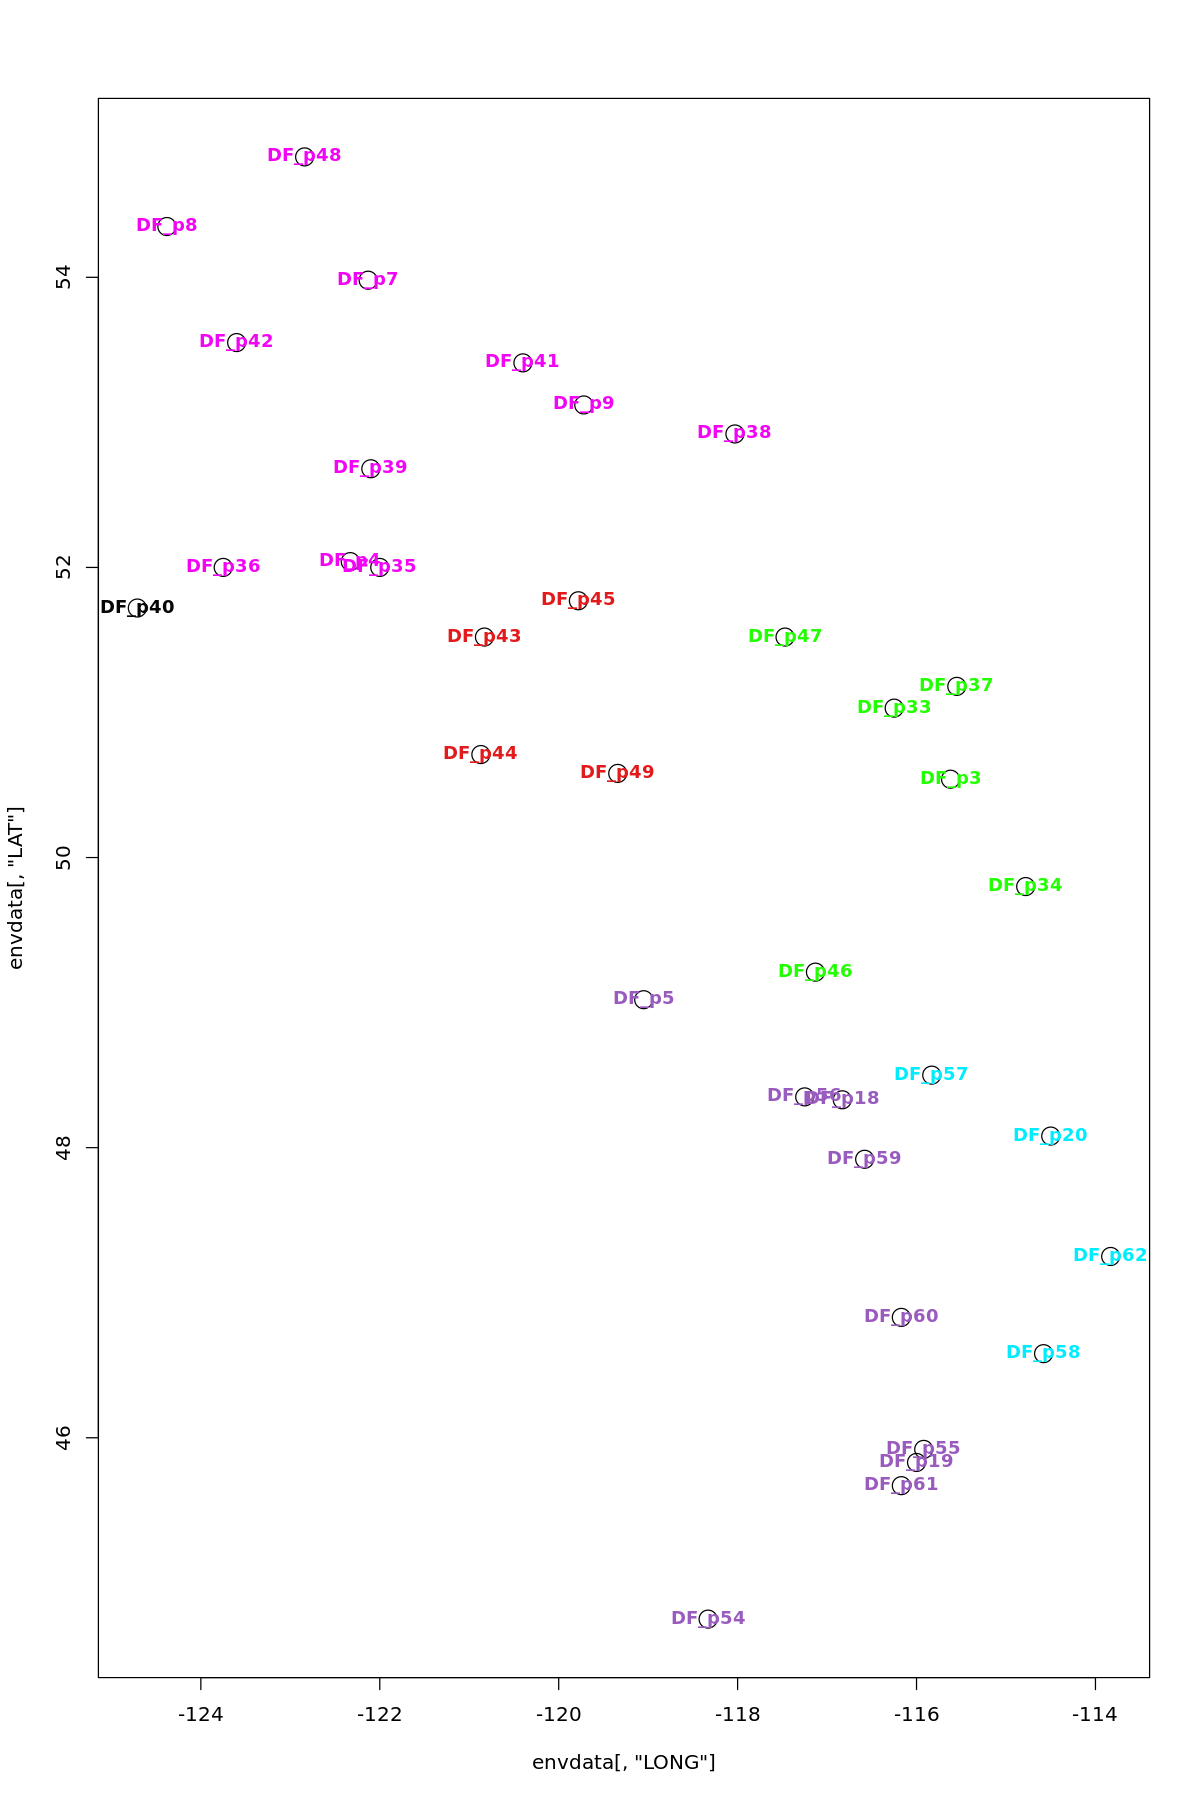

In [5]:
# prep envdata - map is west interior of North America
envdata <- prep_envdata(env_file, pops, plot=TRUE)

In [6]:
head(envdata)

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,⋯,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,ElevationCentstd,group,group_color
,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>",<chr>,<chr>
DF_p18,18,DF_p18,FDI,-116.82999999999999829,48.329999999999998295,823,1.22552466733641707286,1.20629067850128168793,1.15128256864617384281,-0.58984597390975224140,⋯,0.96017836999805172837,0.95740552254900490592,-0.201212110943951749675,1.36051905069598610964,1.17484044532023412799,1.28064740131195065054,0.83220020363160385202,-0.67652556520478523971,Tri-state,#995bbe
DF_p19,19,DF_p19,FDI,-116.00000000000000000,45.829999999999998295,686,2.07837516682784251287,2.02411486731571121922,2.02252343140543988653,-1.16934377283863555341,⋯,1.68178481370824606245,1.71360734571888206901,-1.243392177698307676792,1.89149771677938827175,2.06785835538596307615,2.23937009585615731666,0.62466576623276837132,-1.09375258580374934425,Tri-state,#995bbe
DF_p20,20,DF_p20,FDI,-114.50000000000000000,48.079999999999998295,1341,0.52317719716700883392,0.74626457229316600639,0.71566213726654082095,-0.37253429931142328924,⋯,0.13548529147211543777,0.15394108543101048259,-0.854887182399346579054,0.82954038461258305936,0.60655632073295329132,0.44532465755066130697,0.88633962208347394363,0.90101893603801319621,Montana,#00ecff
DF_p3,3,DF_p3,FDI,-115.62000000000000455,50.539999999999999147,1525,-1.28285915469718481141,-1.14495386434020174349,-1.06312129086696094404,0.49671239908190284451,⋯,-1.30772759594827303609,-1.35846256090874373257,-0.065543699887171694152,-1.20941769314768032828,-0.93592916028966621766,-0.80765945809127259736,-1.33337653444320114460,1.46138223377676790271,Eastern BC,#22ff00
DF_p33,33,DF_p33,FDI,-116.25000000000000000,51.030000000000001137,1524,-1.63403288978188920844,-1.50275194694651492711,-1.31723320917174713252,0.49671239908190284451,⋯,-1.72007413521124119526,-1.50025040275309562432,1.476142789394419896354,-1.42180915958104114871,-1.13888777621369530202,-1.09242857528262105049,-1.51384126261610152397,1.45833678107166586635,Eastern BC,#22ff00
DF_p34,34,DF_p34,FDI,-114.78000000000000114,49.799999999999997158,1615,-1.43336218401920101329,-1.29829589974290748877,-0.80900937256217519966,-0.22765984957920054610,⋯,-0.79229442186956289262,-0.79131119353133583250,0.729966528582129514646,-0.82711305356763131780,-1.66658017761617105457,-1.36770538856759138469,-1.27021387958268583418,1.73547297723594140528,Eastern BC,#22ff00


In [7]:
# Confirm that genotypes and environmental data are in the same order
identical(rownames(snps_imp), rownames(envstd))

[1] TRUE

In [8]:
dim(envstd)

[1] 35 20

In [9]:
dim(envdata)

[1] 35 28

In [10]:
head(envstd)

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,ElevationCentstd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
DF_p18,1.22552466733641707286,1.20629067850128168793,1.15128256864617384281,-0.58984597390975224140,0.468186525007194653814,-0.31015575556614333186,-0.37570873744159877239,0.593788251894302732126,-1.23238449169583685894,1.17261522256665773334,1.18735619292091443278,-0.90592652750197699696,0.96017836999805172837,0.95740552254900490592,-0.201212110943951749675,1.36051905069598610964,1.17484044532023412799,1.28064740131195065054,0.83220020363160385202,-0.67652556520478523971
DF_p19,2.07837516682784251287,2.02411486731571121922,2.02252343140543988653,-1.16934377283863555341,-0.114649685796114300662,0.56309831350358086066,0.38468866871429757692,0.076551098676268539145,-1.80193421072001425109,2.14192508015524918363,2.06976954155273640268,-1.65492090063353369800,1.68178481370824606245,1.71360734571888206901,-1.243392177698307676792,1.89149771677938827175,2.06785835538596307615,2.23937009585615731666,0.62466576623276837132,-1.09375258580374934425
DF_p20,0.52317719716700883392,0.74626457229316600639,0.71566213726654082095,-0.37253429931142328924,-0.803456116745479342889,-0.56610953443140732411,0.87134300865407099401,0.681718567941368758234,-0.68601412170171294225,0.55289252673132860405,0.34696252755727458039,-0.15693215437042024041,0.13548529147211543777,0.15394108543101048259,-0.854887182399346579054,0.82954038461258305936,0.60655632073295329132,0.44532465755066130697,0.88633962208347394363,0.90101893603801319621
DF_p3,-1.28285915469718481141,-1.14495386434020174349,-1.06312129086696094404,0.49671239908190284451,-0.241813949971381697557,1.02983755731670933997,-0.52778821867277803115,-1.268265499690620412565,1.28091921027713295800,-1.18233102160759284693,-1.33382480317000529091,1.34105659189269310616,-1.30772759594827303609,-1.35846256090874373257,-0.065543699887171694152,-1.20941769314768032828,-0.93592916028966621766,-0.80765945809127259736,-1.33337653444320114460,1.46138223377676790271
DF_p33,-1.63403288978188920844,-1.50275194694651492711,-1.31723320917174713252,0.49671239908190284451,0.715450372014658997344,1.07500587123410884516,-1.17666067192580969802,-1.407919531059489415270,1.73457218415104175158,-1.50967172761292056649,-1.54392321951091515686,1.25783499487807581829,-1.72007413521124119526,-1.50025040275309562432,1.476142789394419896354,-1.42180915958104114871,-1.13888777621369530202,-1.09242857528262105049,-1.51384126261610152397,1.45833678107166586635
DF_p34,-1.43336218401920101329,-1.29829589974290748877,-0.80900937256217519966,-0.22765984957920054610,0.019579259722223515267,0.12647127896871876440,-0.78125402072474348092,-0.833786290987471367941,1.31403256603435258931,-1.44293236036911576292,-0.99766733702454923893,0.75850541279037131392,-0.79229442186956289262,-0.79131119353133583250,0.729966528582129514646,-0.82711305356763131780,-1.66658017761617105457,-1.36770538856759138469,-1.27021387958268583418,1.73547297723594140528


                  user                 system                elapsed 
551.567999999999983629  51.555999999999997385  94.725999999999999091 
rda(formula = snps ~ MAT + MWMT + MCMT + TD + MAP + MSP + AHM + 
    SHM + DD_0 + DD5 + NFFD + bFFP + eFFP + FFP + PAS + EMT + 
    EXT + Eref + CMD + ElevationCentstd, data = envdata)
$r.squared
[1] 0.68460508549743448459

$adj.r.squared
[1] 0.2340409219223408277



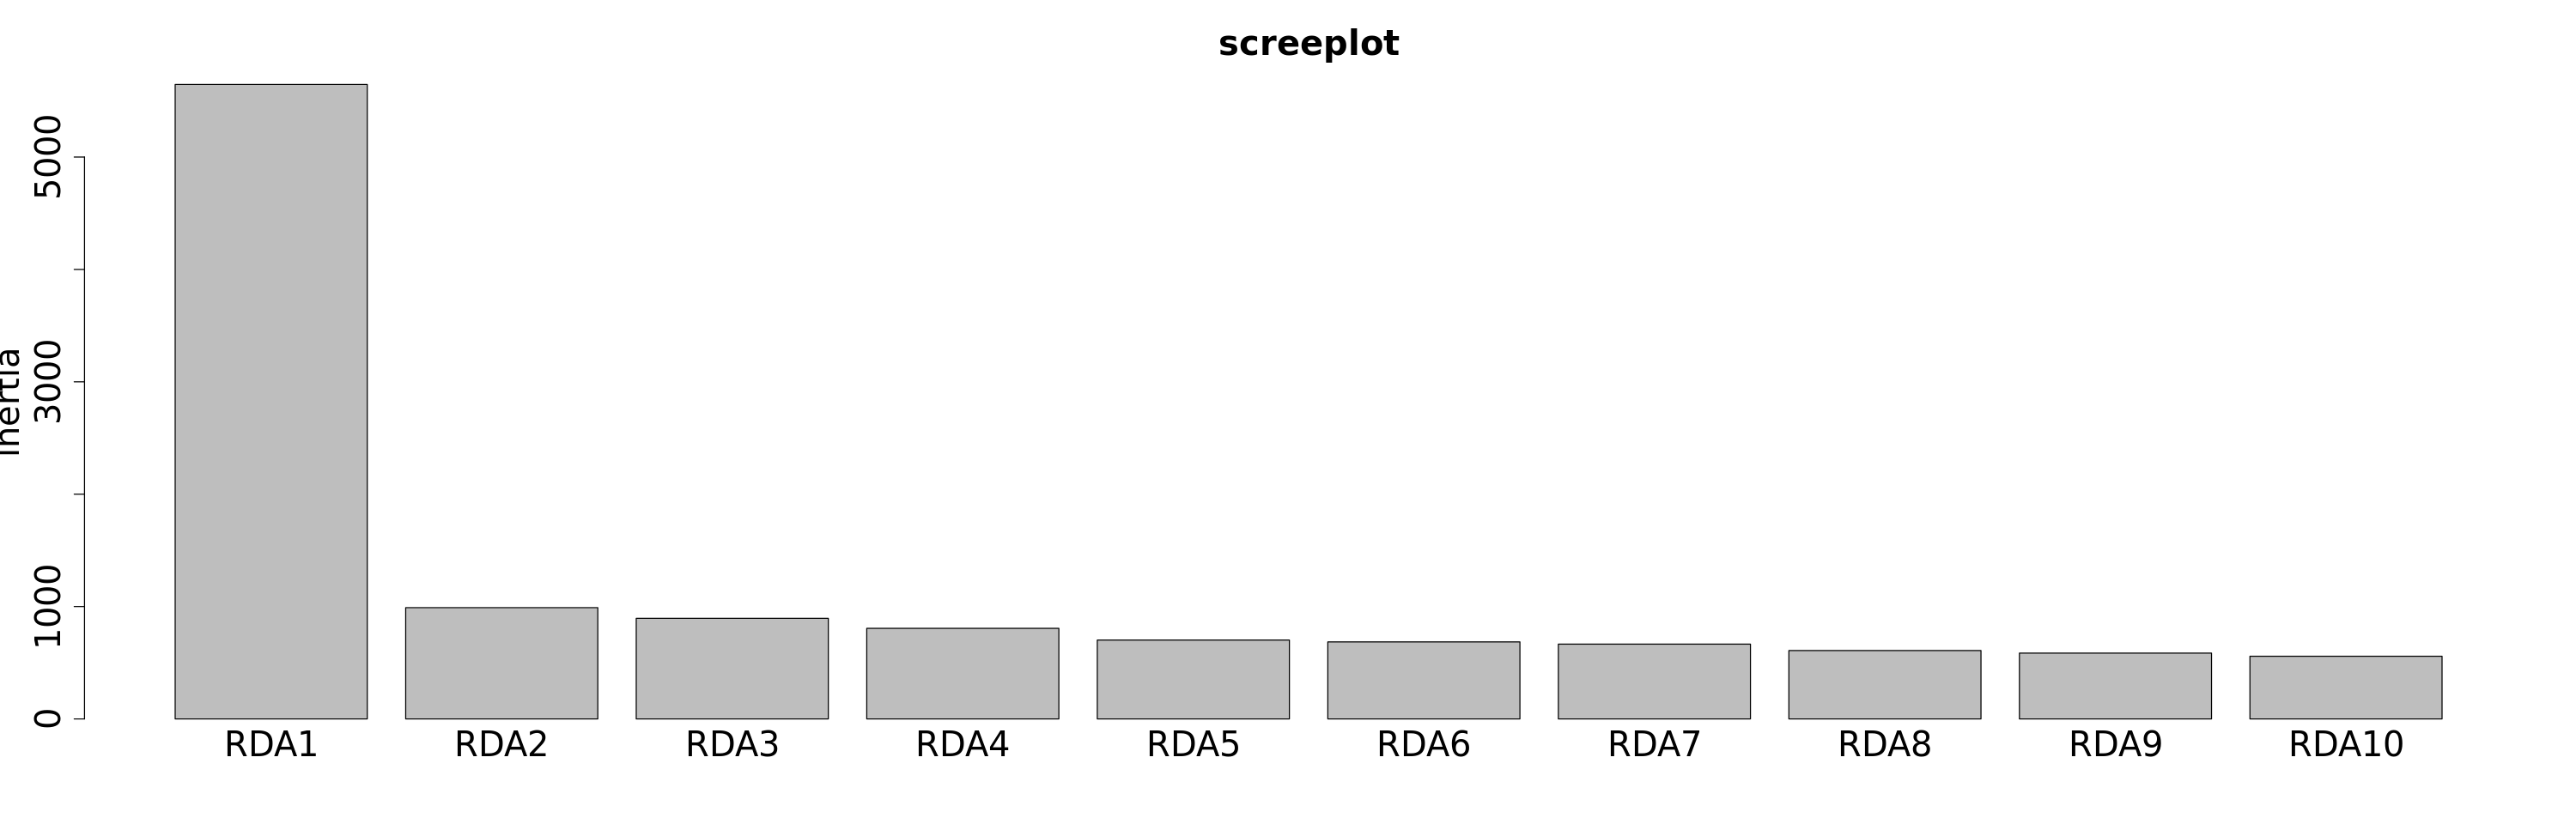

png 
  2

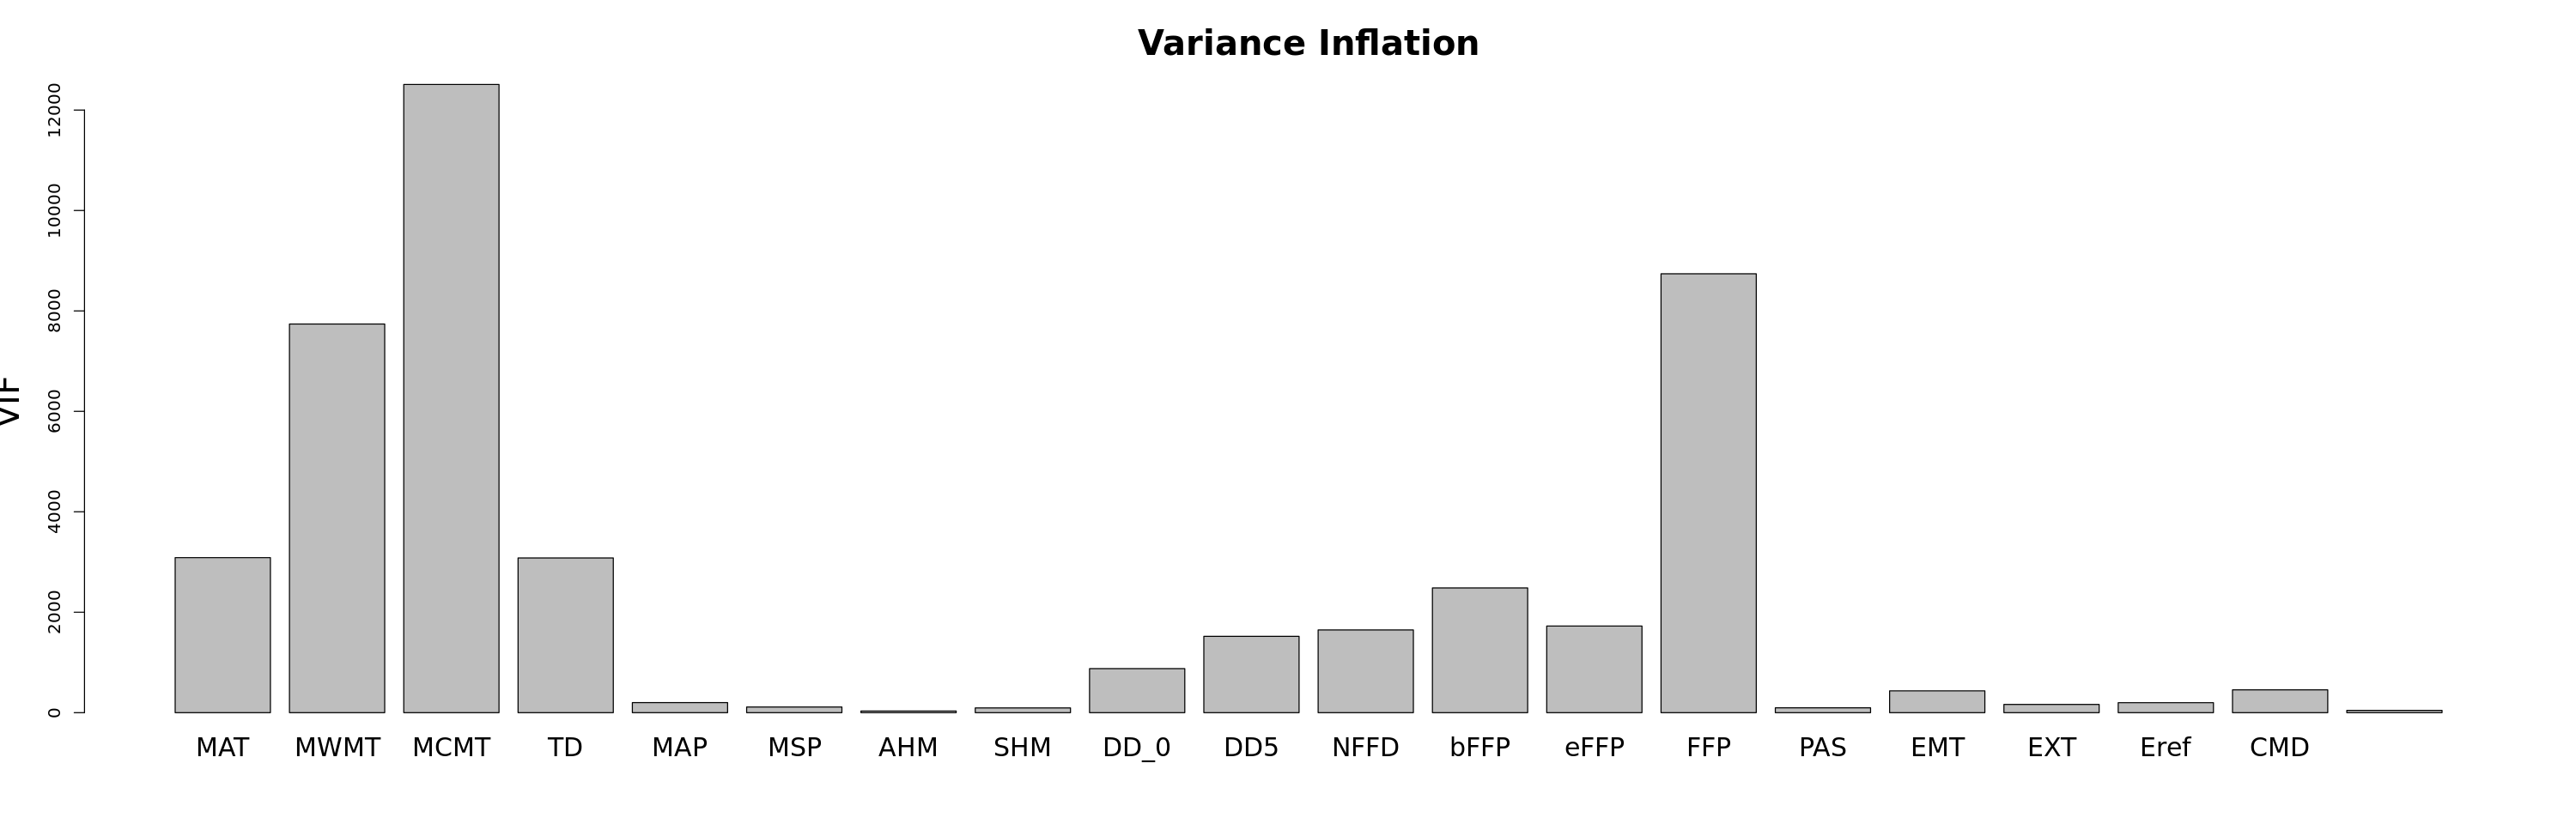

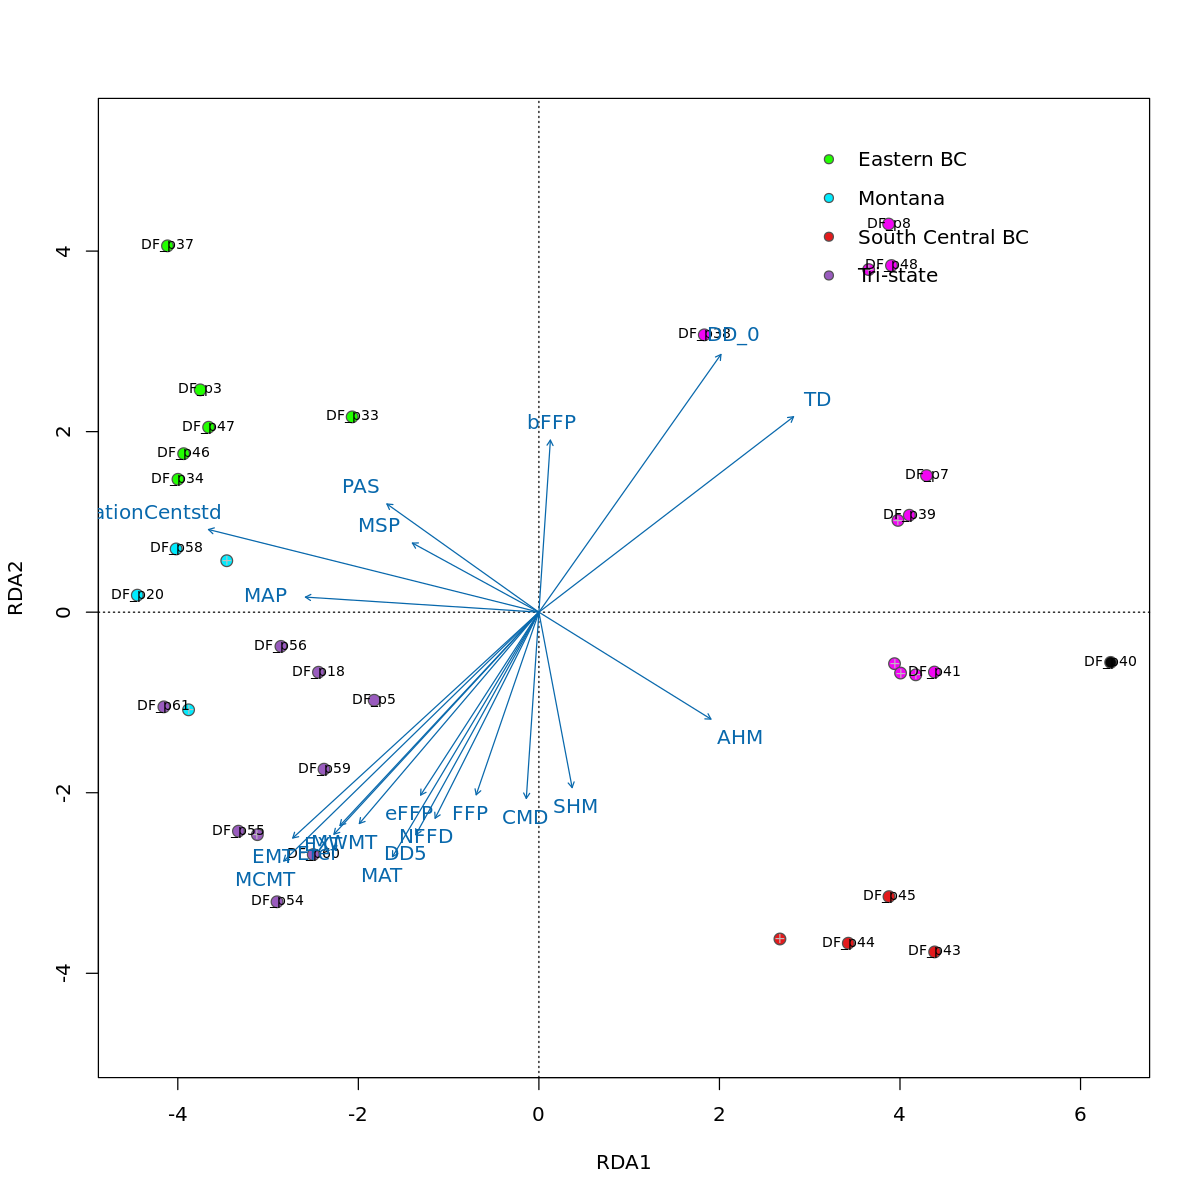

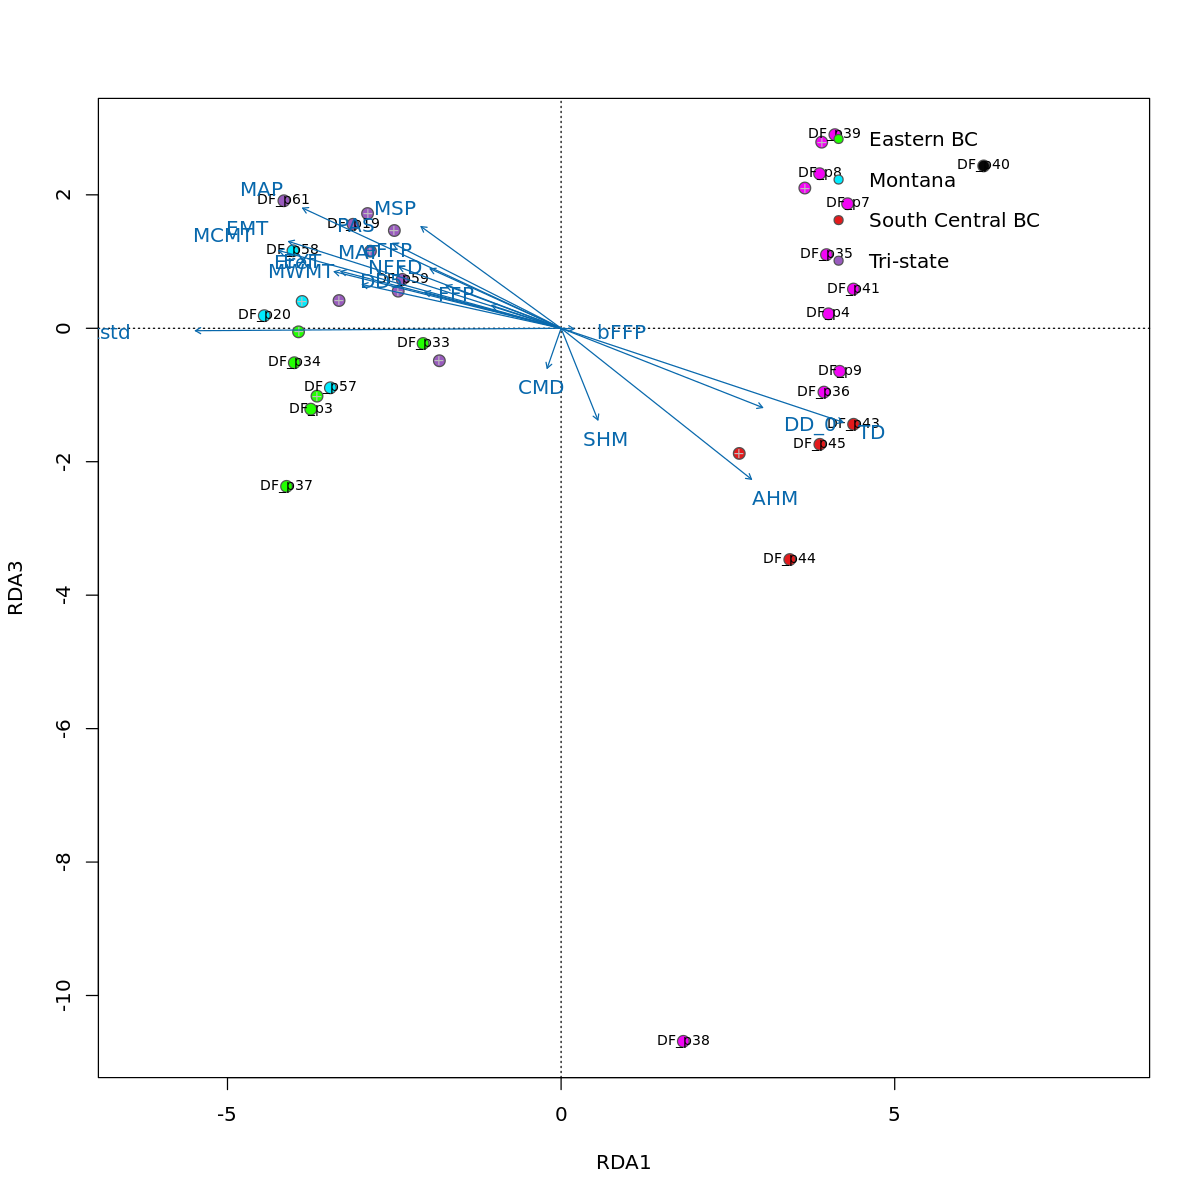

In [11]:
# do the RDA, plot

int.rda <- prep_rda(snps_imp, envstd)

# plot axis 1 vs 2
# save a pdf
pdf(paste(rdadir, 'RDA_interior_all_vars_ax1-2.pdf', sep='/'))
plot_rda(int.rda, axes=c(1,2))
dev.off()
# now so it shows up in notebook
plot_rda(int.rda, axes=c(1,2))

# plot axis 1 vs 3
plot_rda(int.rda, axes=c(1,3))

png 
  2

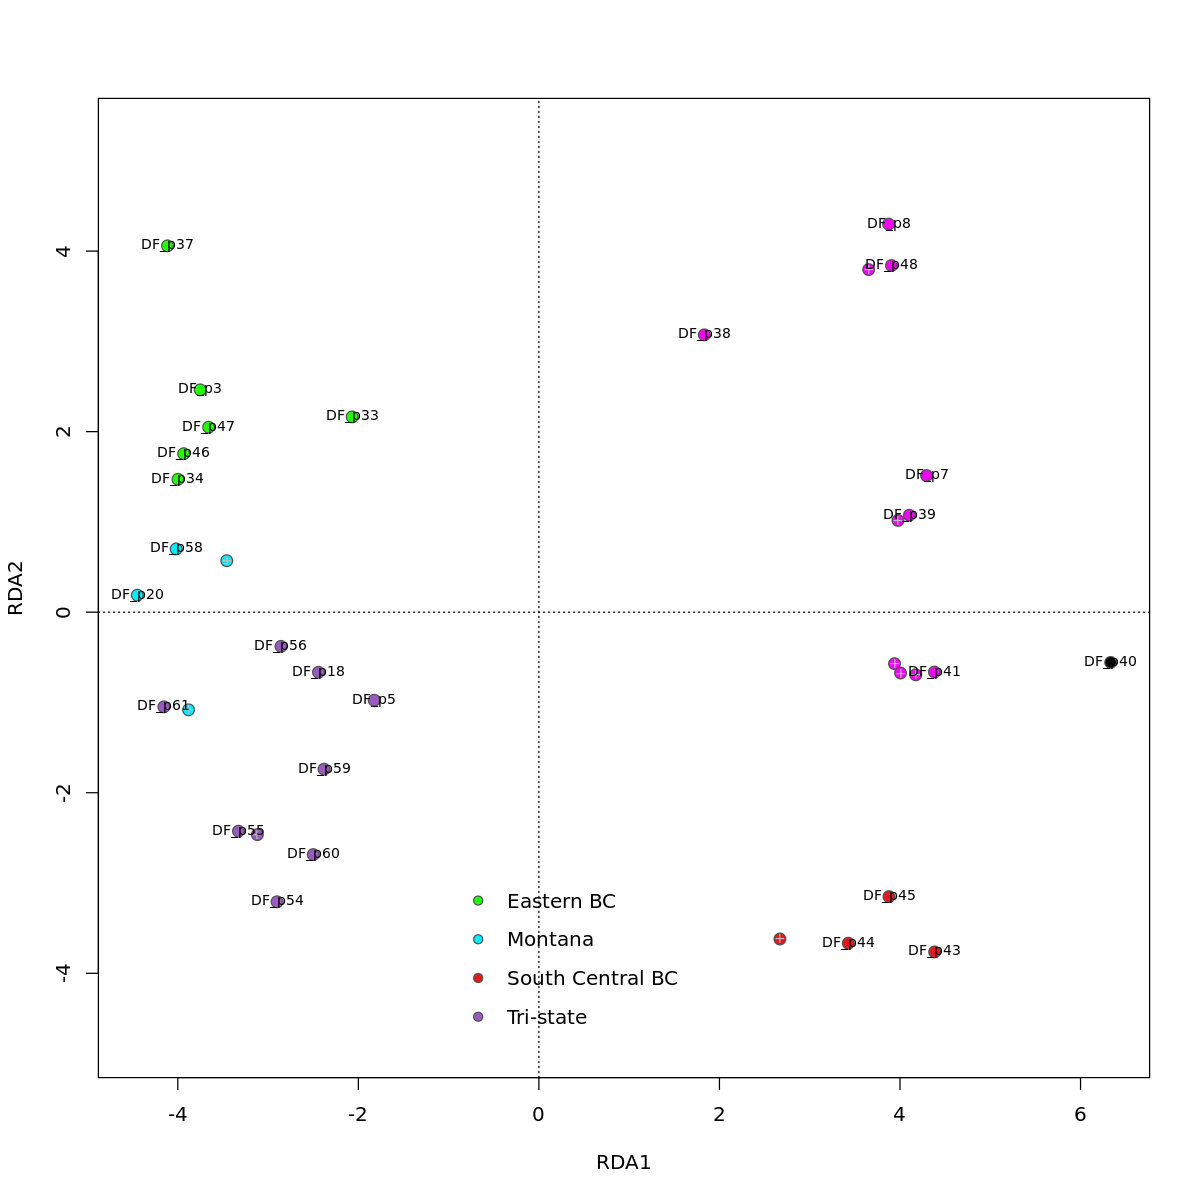

In [19]:
# I re-ran the top of the notebook and stopped here - the rest below was done before saving this fig.

# save a fig showing PCA only (no env vectors)
pdf(paste0(rdadir, '/RDA_interior_all_vars_ax1-2_no-env-vectors.pdf'))
plot_rda(int.rda, axes=c(1,2), vectors=FALSE, legendloc='bottom')
dev.off()
plot_rda(int.rda, axes=c(1,2), vectors=FALSE, legendloc='bottom')

#### compare imputed to no missing data

this shows the same basica overall patterns as imputed data

In [12]:
# load frequency data
nomissinglocidf = read.csv(no_missing_loci_file)
snps_noimp = subset(snps_imp, select = as.vector(nomissinglocidf[ ,'no_missing_loci']))
snps_noimp[1:5,1:20]

,jcf7190000000004-54540,jcf7190000000004-54643,jcf7190000000004-54644,jcf7190000000004-54700,jcf7190000000004-54939,jcf7190000000004-54991,jcf7190000000004-54998,jcf7190000000004-55010,jcf7190000000004-55083,jcf7190000000004-55107,jcf7190000000004-55111,jcf7190000000004-55162,jcf7190000000004-55256,jcf7190000000004-55345,jcf7190000000004-55528,jcf7190000000004-55573,jcf7190000000004-55840,jcf7190000000004-56265,jcf7190000000004-56444,jcf7190000000004-56472
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DF_p18,0.72549999999999992273,0.32140000000000001901,0.80700000000000005063,0.87500000000000000000,0.65620000000000000551,0.72409999999999996589,0.83999999999999996891,0.85189999999999999059,0.92310000000000003162,0.96150000000000002132,0.96299999999999996714,0.90000000000000002220,0.80489999999999994884,0.89829999999999998739,0.90139999999999997904,0.92859999999999998099,0.86959999999999992859,0.75760000000000005116,0.80650000000000010569,0.81250000000000000000
DF_p19,0.89859999999999995435,0.12279999999999999249,0.96550000000000002487,0.96719999999999994866,0.87500000000000000000,0.85709999999999997300,0.87180000000000001936,0.89190000000000002611,0.93750000000000000000,0.92590000000000005631,0.92590000000000005631,0.78120000000000000551,0.84620000000000006324,0.95709999999999995079,0.90359999999999995879,0.92769999999999996909,0.96770000000000000462,0.76599999999999990319,0.97780000000000000249,0.97829999999999994742
DF_p20,0.86670000000000002593,0.25929999999999997495,0.84620000000000006324,0.85290000000000010250,0.80000000000000004441,0.66670000000000007034,0.69230000000000002647,0.61539999999999994706,0.82349999999999989875,0.94120000000000003659,0.94739999999999990887,1.00000000000000000000,0.86959999999999992859,0.86670000000000002593,0.87879999999999991456,0.90910000000000001918,0.94739999999999990887,0.93330000000000001847,0.90000000000000002220,0.92310000000000003162
DF_p3,0.94340000000000001634,0.42859999999999998099,0.90319999999999989182,0.88680000000000003268,0.93019999999999991580,0.95450000000000001510,0.95450000000000001510,0.95349999999999990319,0.85370000000000001439,0.85290000000000010250,0.85290000000000010250,0.79489999999999993996,0.84089999999999998082,0.91180000000000005489,0.89390000000000002789,0.92859999999999998099,0.96250000000000002220,0.94999999999999995559,0.97959999999999991527,0.97870000000000001439
DF_p33,0.87719999999999997975,0.36359999999999997877,0.92540000000000011138,0.89859999999999995435,0.79489999999999993996,0.83719999999999994422,0.84089999999999998082,0.84089999999999998082,0.95120000000000004547,0.92500000000000004441,0.92500000000000004441,0.95239999999999991331,0.92310000000000003162,0.92310000000000003162,0.94669999999999998597,0.94739999999999990887,0.92980000000000007088,0.83329999999999992966,0.86109999999999997655,1.00000000000000000000


In [13]:
# how many pops
nrow(snps_noimp)

[1] 35

In [14]:
# same order as before?
all(rownames(snps_noimp) == rownames(snps_imp))

[1] TRUE

In [15]:
# Confirm that genotypes and environmental data are in the same order
identical(rownames(snps_noimp), rownames(envstd))

[1] TRUE

                  user                 system                elapsed 
208.753000000000042746 141.889999999999986358  18.430000000000006821 
rda(formula = snps ~ MAT + MWMT + MCMT + TD + MAP + MSP + AHM + 
    SHM + DD_0 + DD5 + NFFD + bFFP + eFFP + FFP + PAS + EMT + 
    EXT + Eref + CMD + ElevationCentstd, data = envdata)
$r.squared
[1] 0.69475021566216621505

$adj.r.squared
[1] 0.25867909517954656984



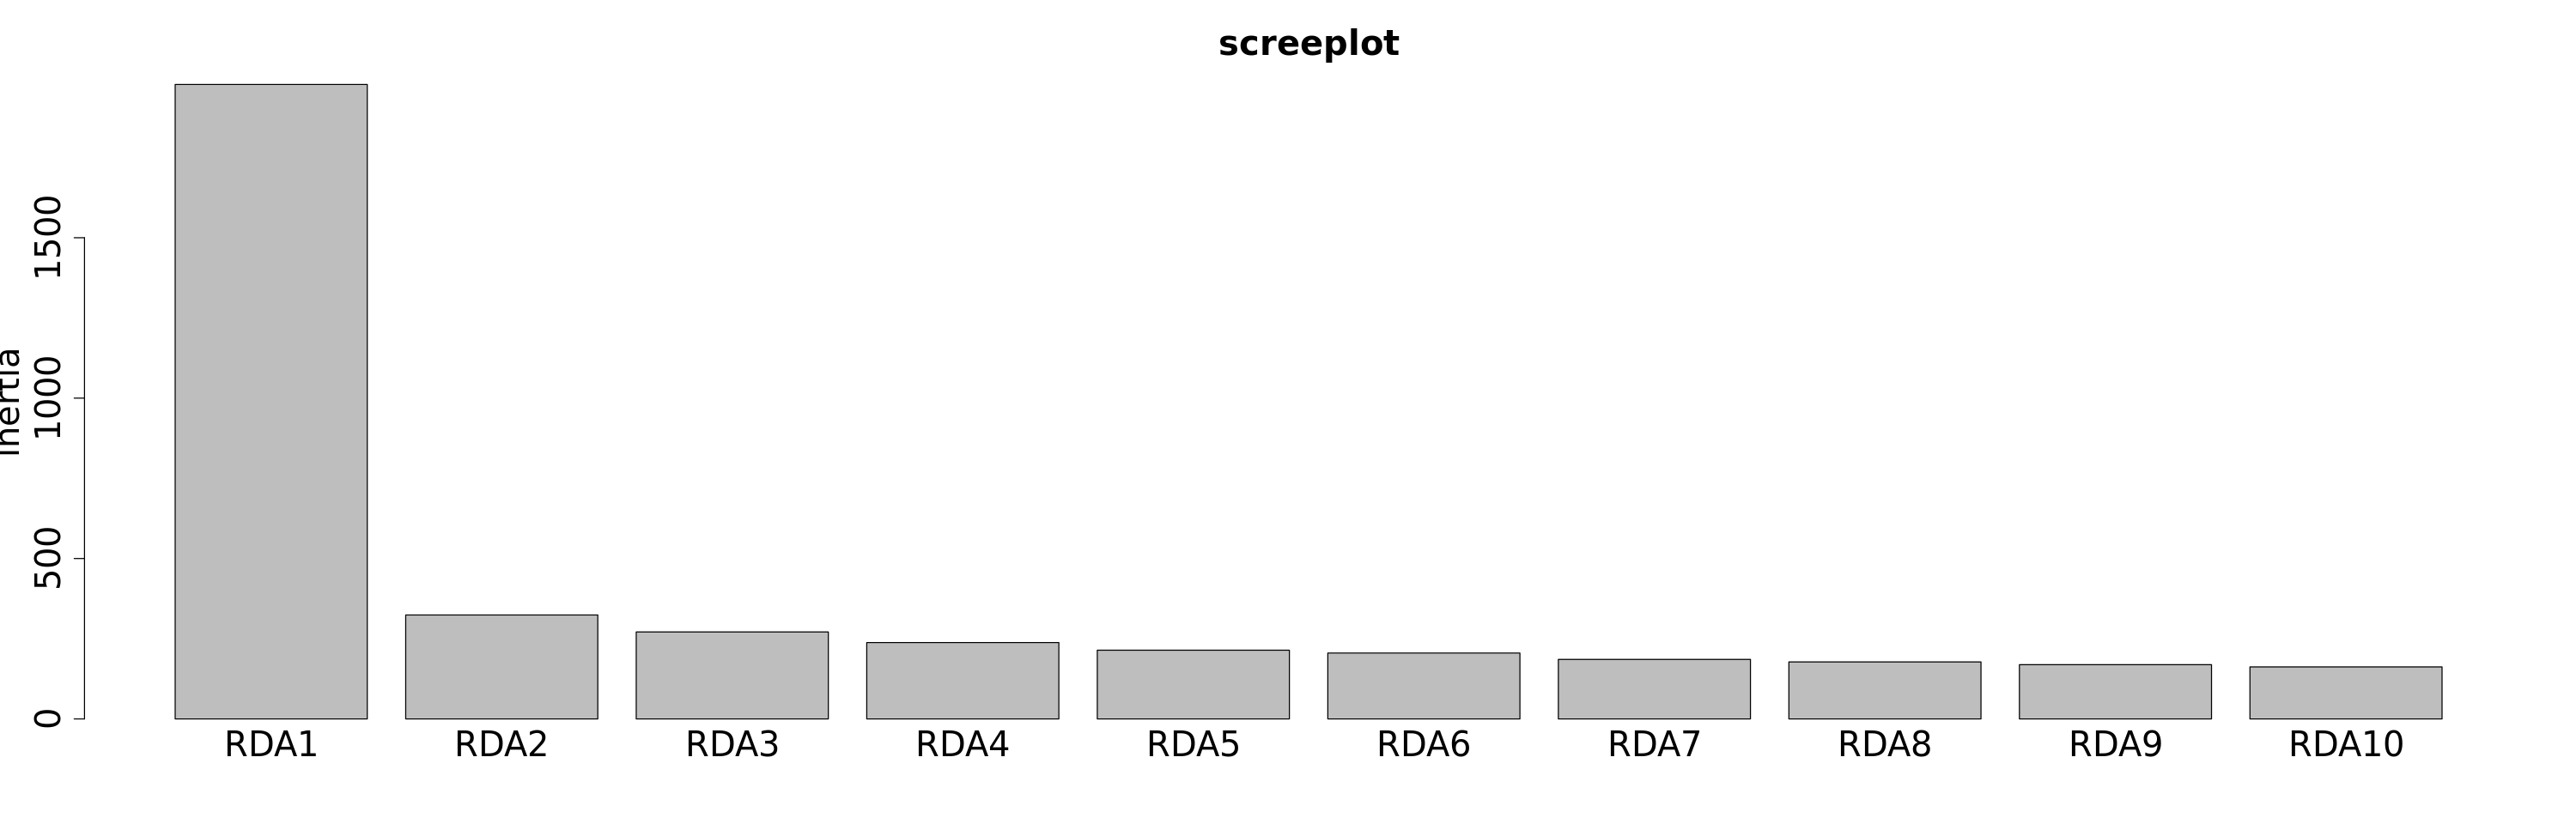

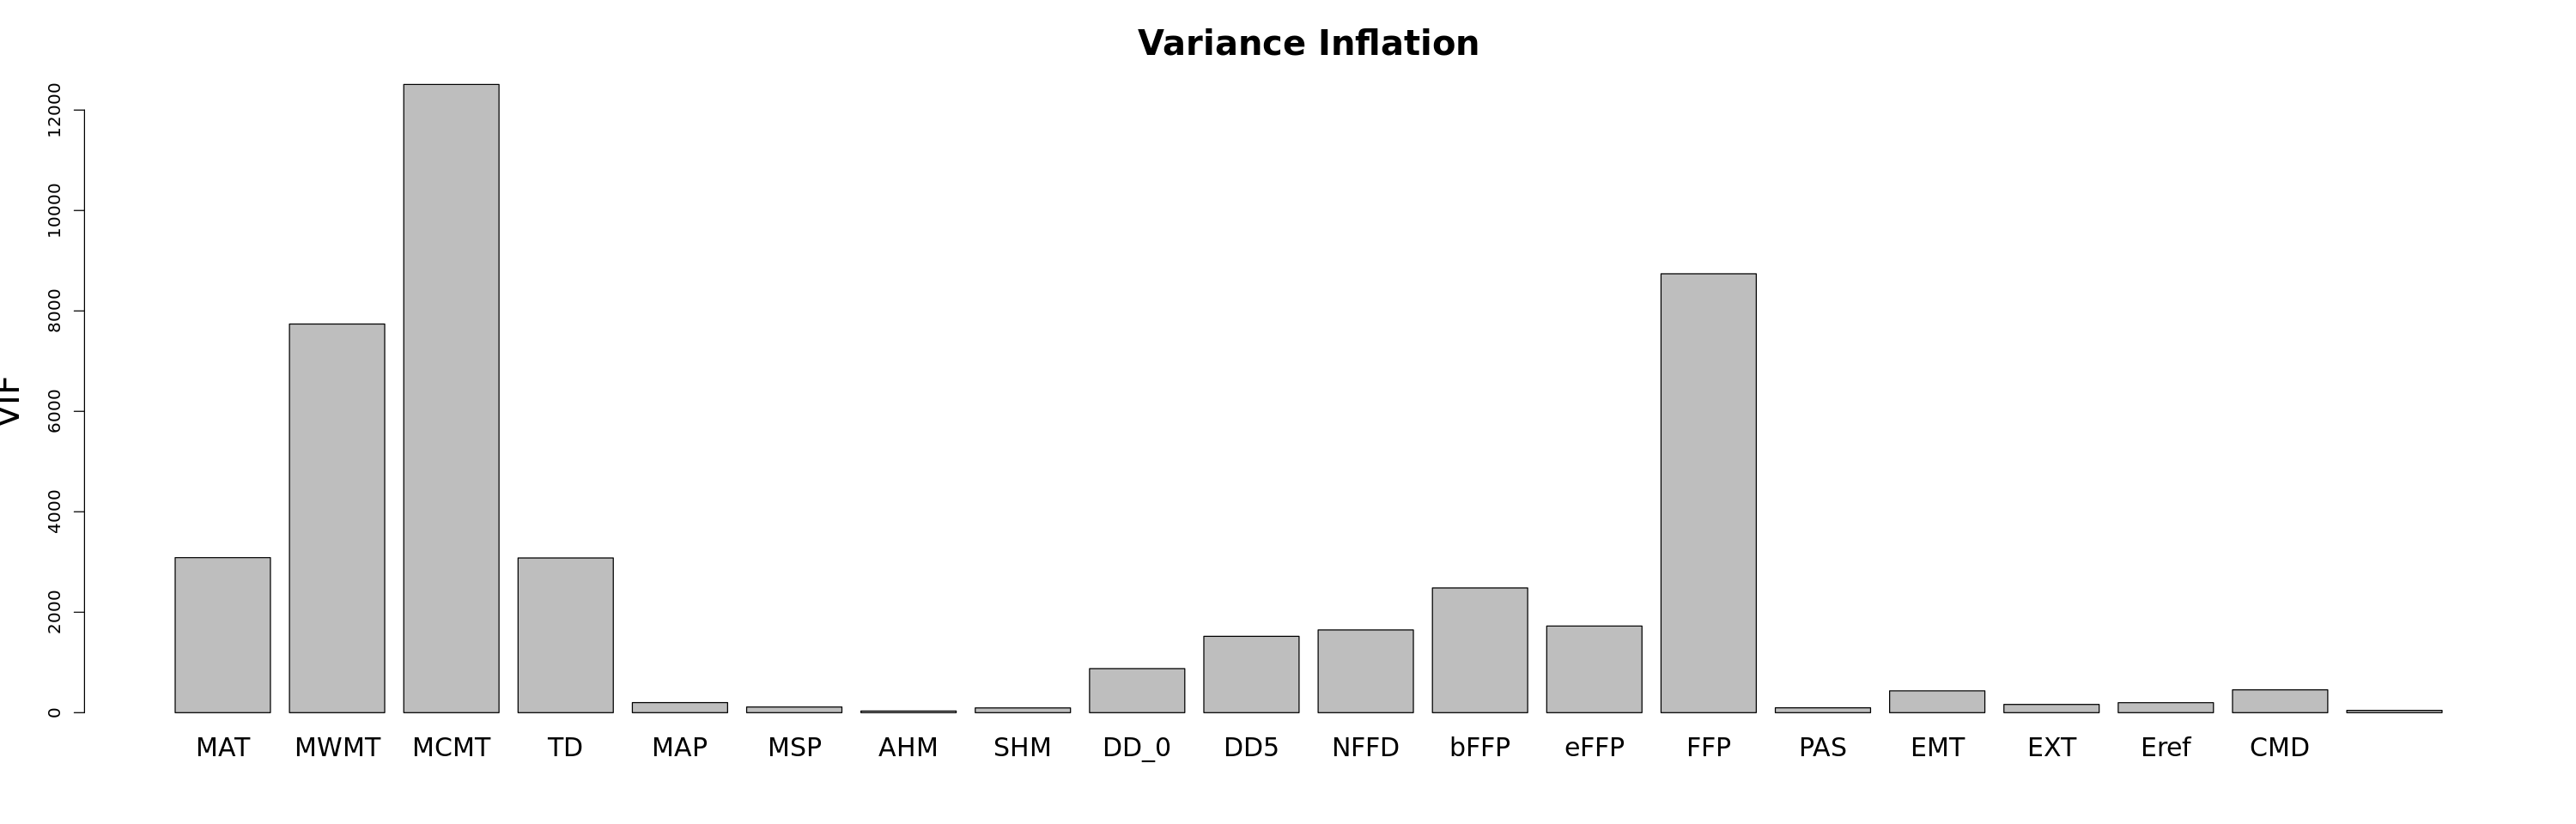

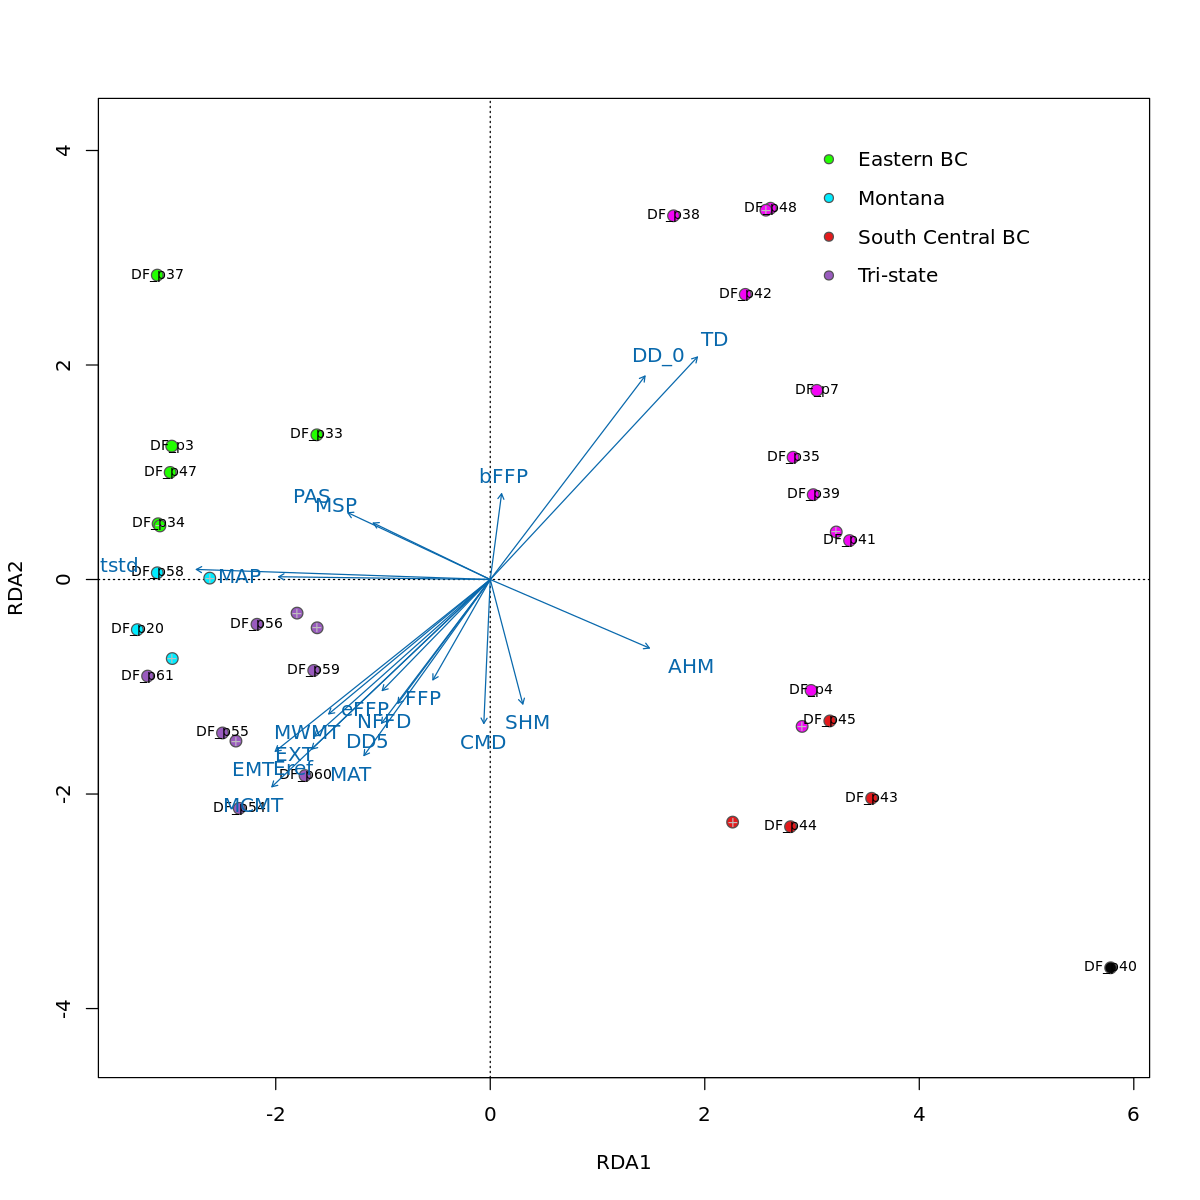

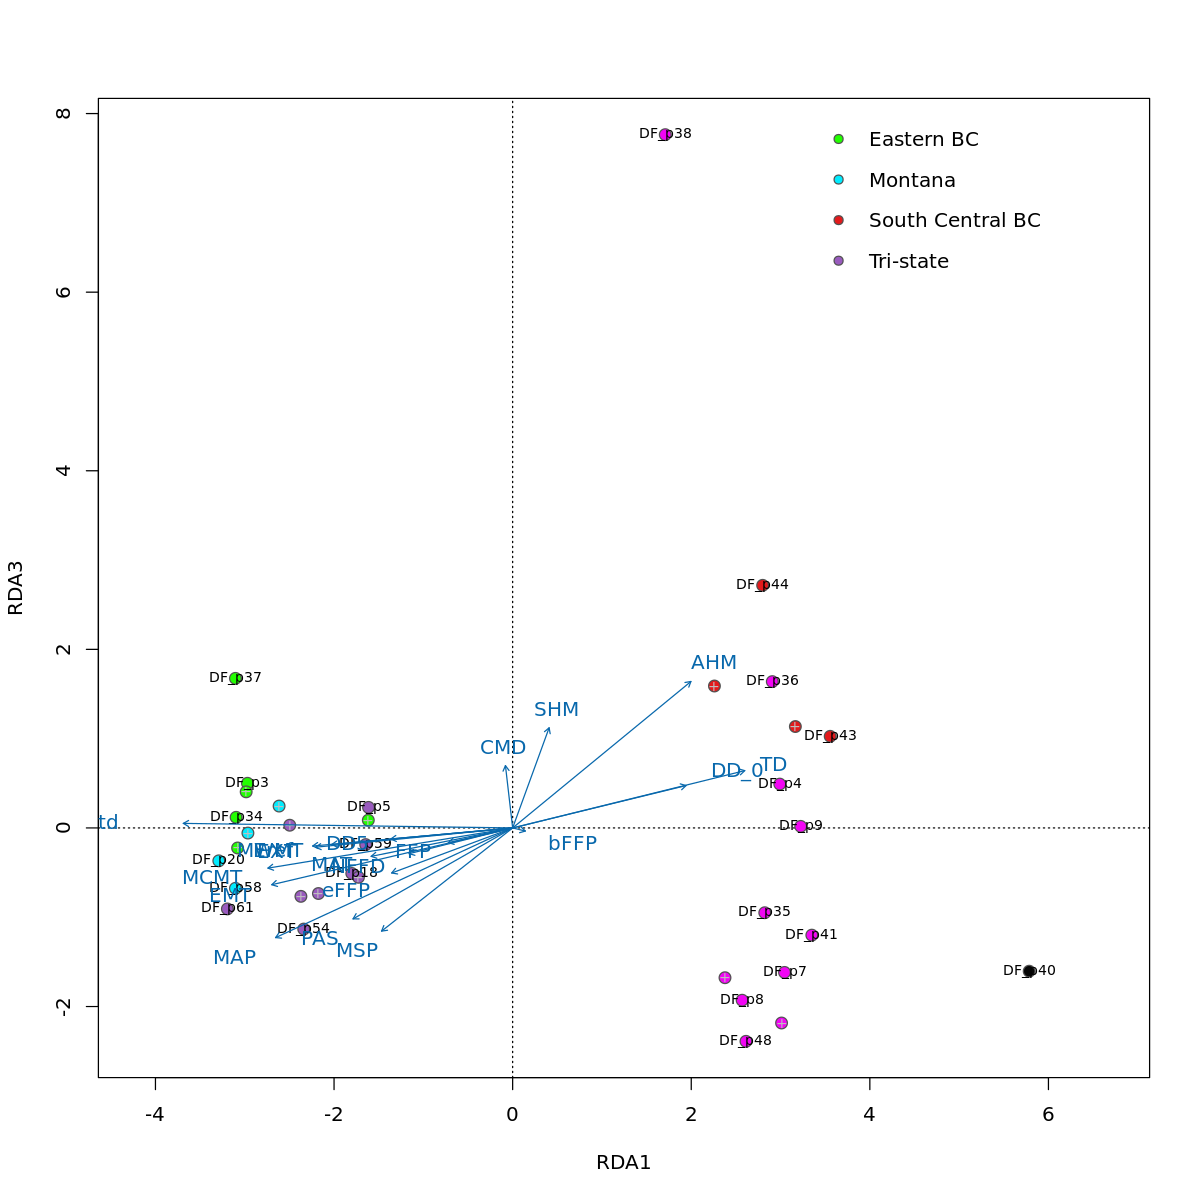

In [16]:
# do the RDA, plot
interior_noimp.rda <- prep_rda(snps_noimp, envstd)

# plot axis 1 vs 2
plot_rda(interior_noimp.rda, axes=c(1,2))

# plot axis 1 vs 3
plot_rda(interior_noimp.rda, axes=c(1,3))

# move forward with imputed SNPs

- exclude environmental variables to reduce variance inflation

#### get pairwise correlation among envs, build function so I can choose next env to eliminate

In [11]:
main_envs = colnames(envdata)[7:26]  # main 19 climatic variables + cent/std Elevation
len(main_envs)

[1] 20

In [12]:
# build environmental correlation matrix to explore variables after widdling due to variance inflation factor below
cormat = matrix(NA, ncol=len(main_envs), nrow=len(main_envs))
colnames(cormat) = main_envs
rownames(cormat) = main_envs
i = 0
for (envi in main_envs){
    j = 0
    for (envj in main_envs){
        if (i > j){
            cormat[envi,envj] = cor(envdata[,envi], envdata[,envj])
        }
        j = j + 1
    }
    i = i + 1
}
cormat

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,ElevationCentstd
MAT,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MWMT,0.976621004880354859345,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MCMT,0.929801259204891428212,0.880950566380918731468,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TD,-0.470641021791676272823,-0.340635259330046957782,-0.744733388518690309077,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MAP,0.063100985371314533001,0.061664217590495937205,0.262004730224034143582,-0.425241008878246395941,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MSP,-0.102271653023443293007,-0.086861159327289369503,0.035792018239401521273,-0.183380372680568920485,0.831565425179777828468,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AHM,0.230451642019734920241,0.221329950949808701433,0.029111972773560448186,0.247995246559092274996,-0.860219377771292759149,-0.778877947769236800291,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SHM,0.483474057067365348139,0.472774559859374443604,0.342259670080018119087,-0.023700695395585964081,-0.640298264209381740031,-0.862881743772169418349,0.815582259070160908720,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
DD_0,-0.973818759707899550548,-0.925158129590316069546,-0.976444883509706929026,0.635606205976778082523,-0.170469240388432169420,0.047443363261805787667,-0.133963849269793849883,-0.43110163783387928094,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
DD5,0.981399735988919941221,0.987372464255255377630,0.856796472546260456937,-0.310140143684776103949,-0.010582423849757343140,-0.125572371434512830568,0.287552356031393729907,0.49690354660881613791,-0.91512496599999992863,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [13]:
avg_cors <- function(env_names){
    #------------------------------------------#
    # sort each env in env_names by descending #
    # average correlation with all other envs. #
    #------------------------------------------#
    .cormat = cormat[env_names, env_names]  # only the envs that matter
    z = data.frame('avg' = rep(0, len(env_names)))  # blank df to fill in
    rownames(z) = env_names
    for (env_name in env_names){
        x = cormat[env_name,][which(is.na(.cormat[env_name, ])==FALSE)]
        y = cormat[,env_name][which(is.na(.cormat[,env_name])==FALSE)]
        z[env_name, 'avg'] = abs(.mean(c(as.vector(x), as.vector(y))))
    }
    return(z[rev(rownames(z)[order(z$avg)]), ,drop=F])
}
z = avg_cors(main_envs)
z

,avg
,<dbl>
DD_0,0.4463003042904749029240
bFFP,0.3747470559648343191306
MWMT,0.3532451097439798237687
MAT,0.3485778847805180435948
EMT,0.3459407302839764830615
DD5,0.3421413380672717607922
EXT,0.3343628743468570752029
MCMT,0.3325711429217477754783
NFFD,0.3300049634385509023105


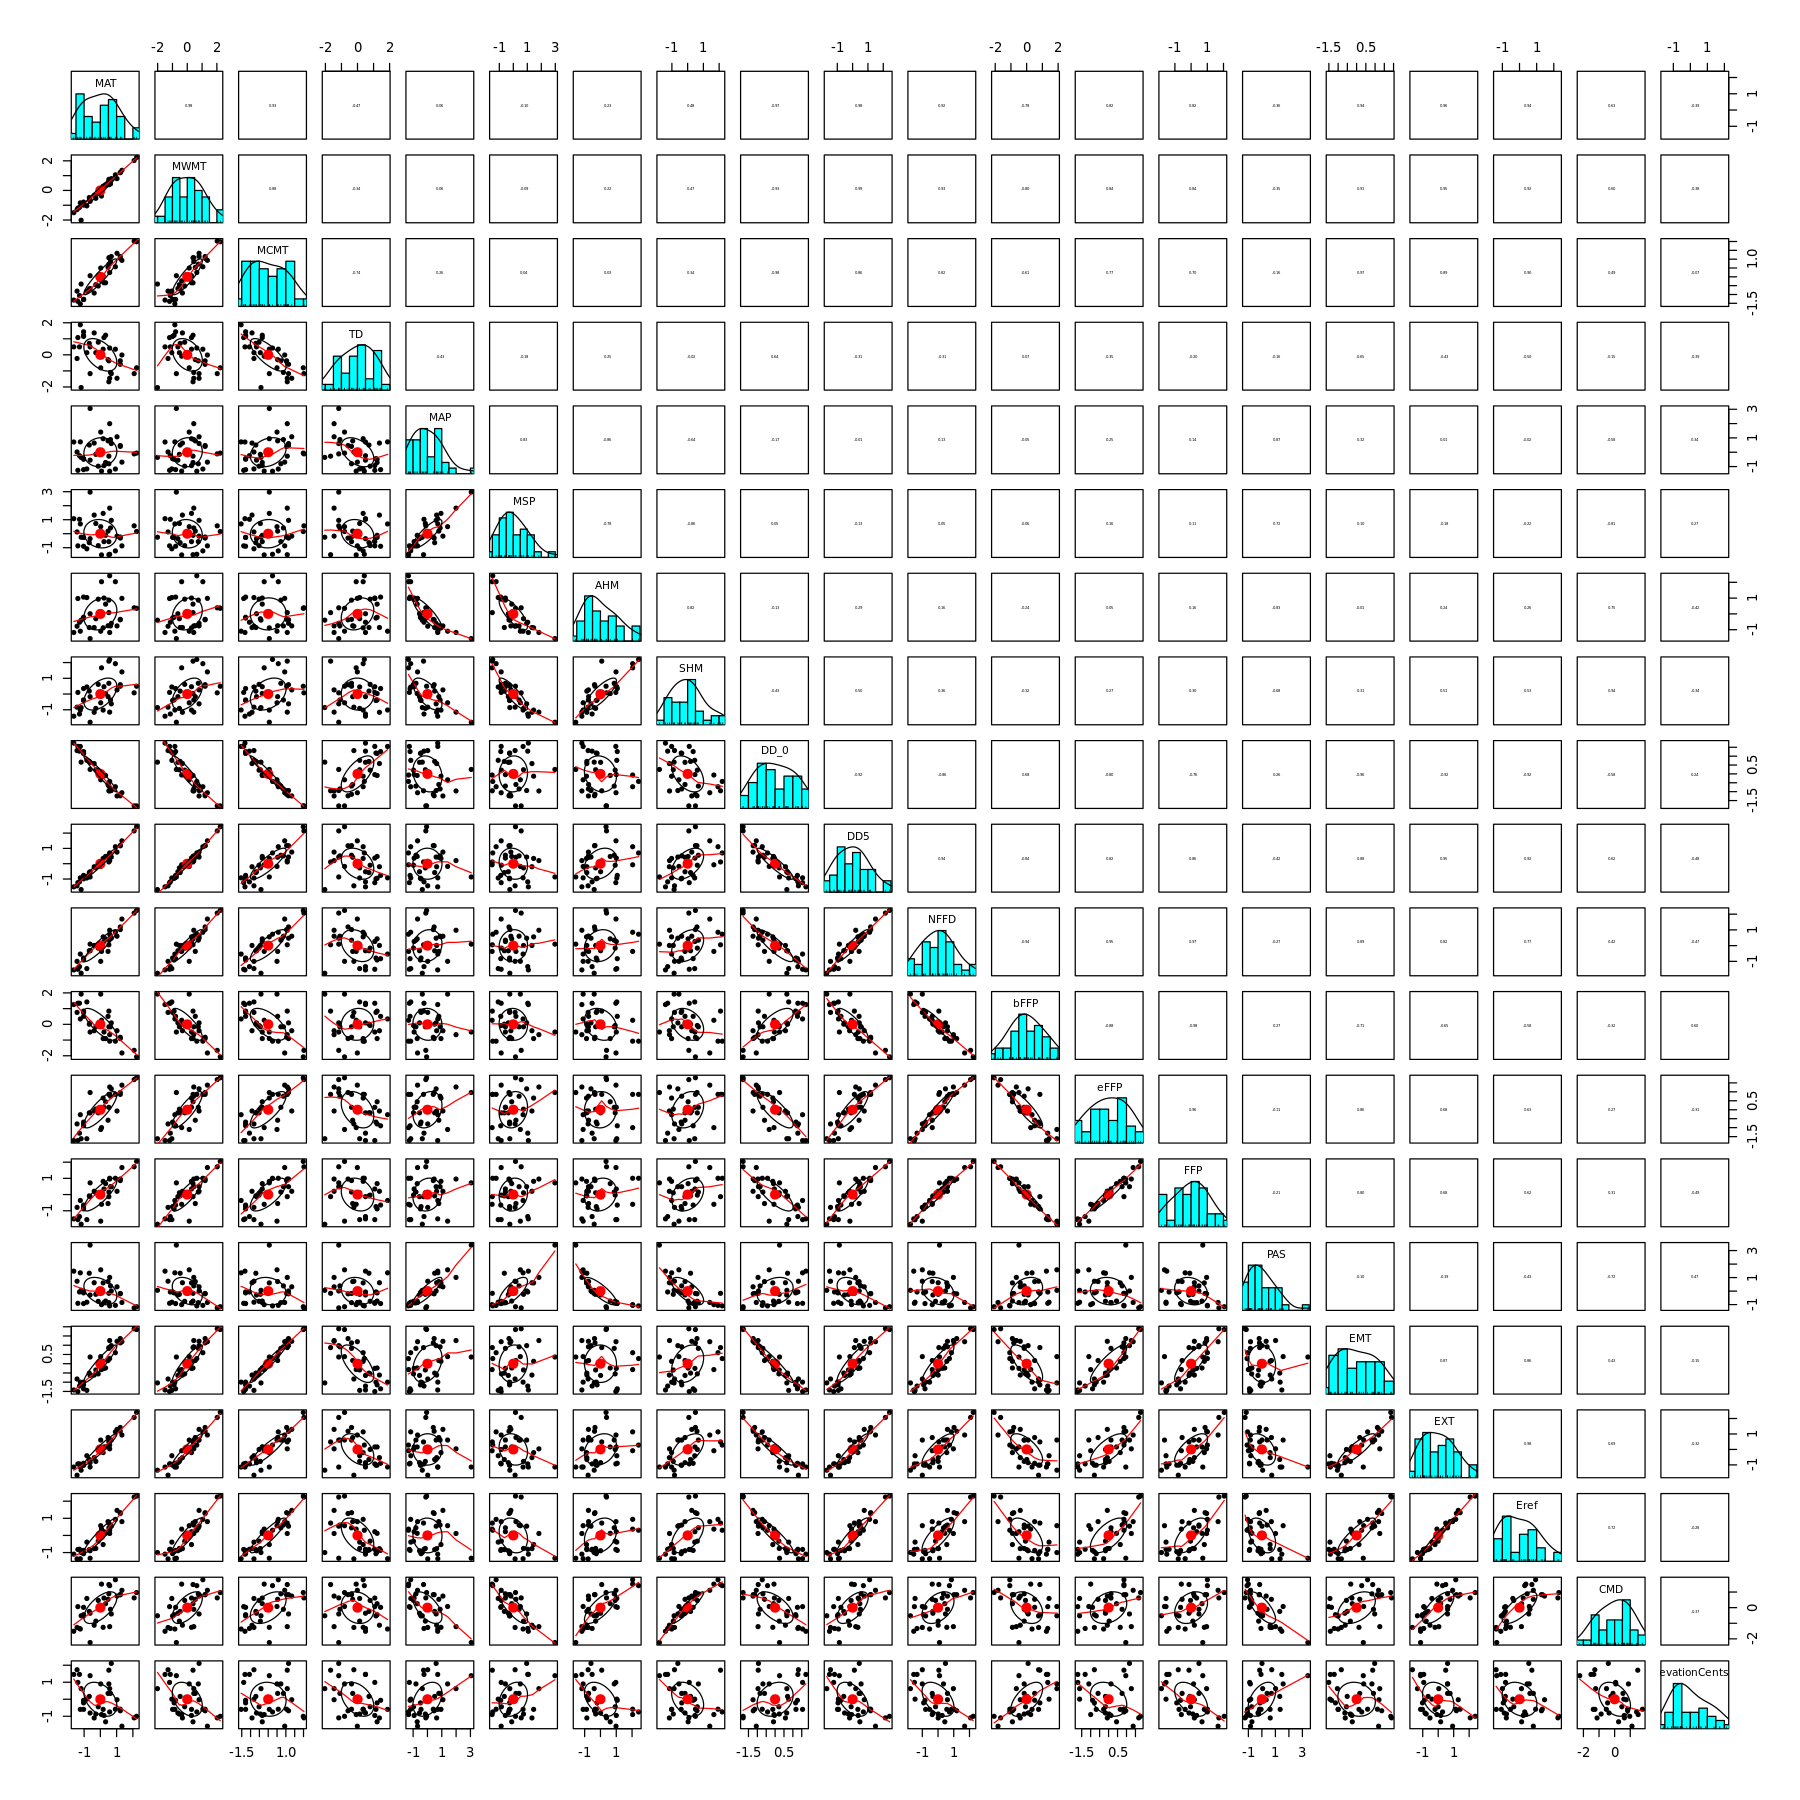

In [14]:
options(repr.plot.width=15, repr.plot.height=15)
pairs.panels(envdata[,main_envs], scale=F)

#### narrow down interior envs

There are 7 environmental attributes in the envdata table.                  user                 system                elapsed 
635.522000000000161890 332.963999999999998636  65.577999999999974534 
rda(formula = snps ~ TD + MSP + AHM + DD_0 + FFP + PAS + ElevationCentstd, 
    data = envdata)
$r.squared
[1] 0.33560590138752749434

$adj.r.squared
[1] 0.16335557952503454437



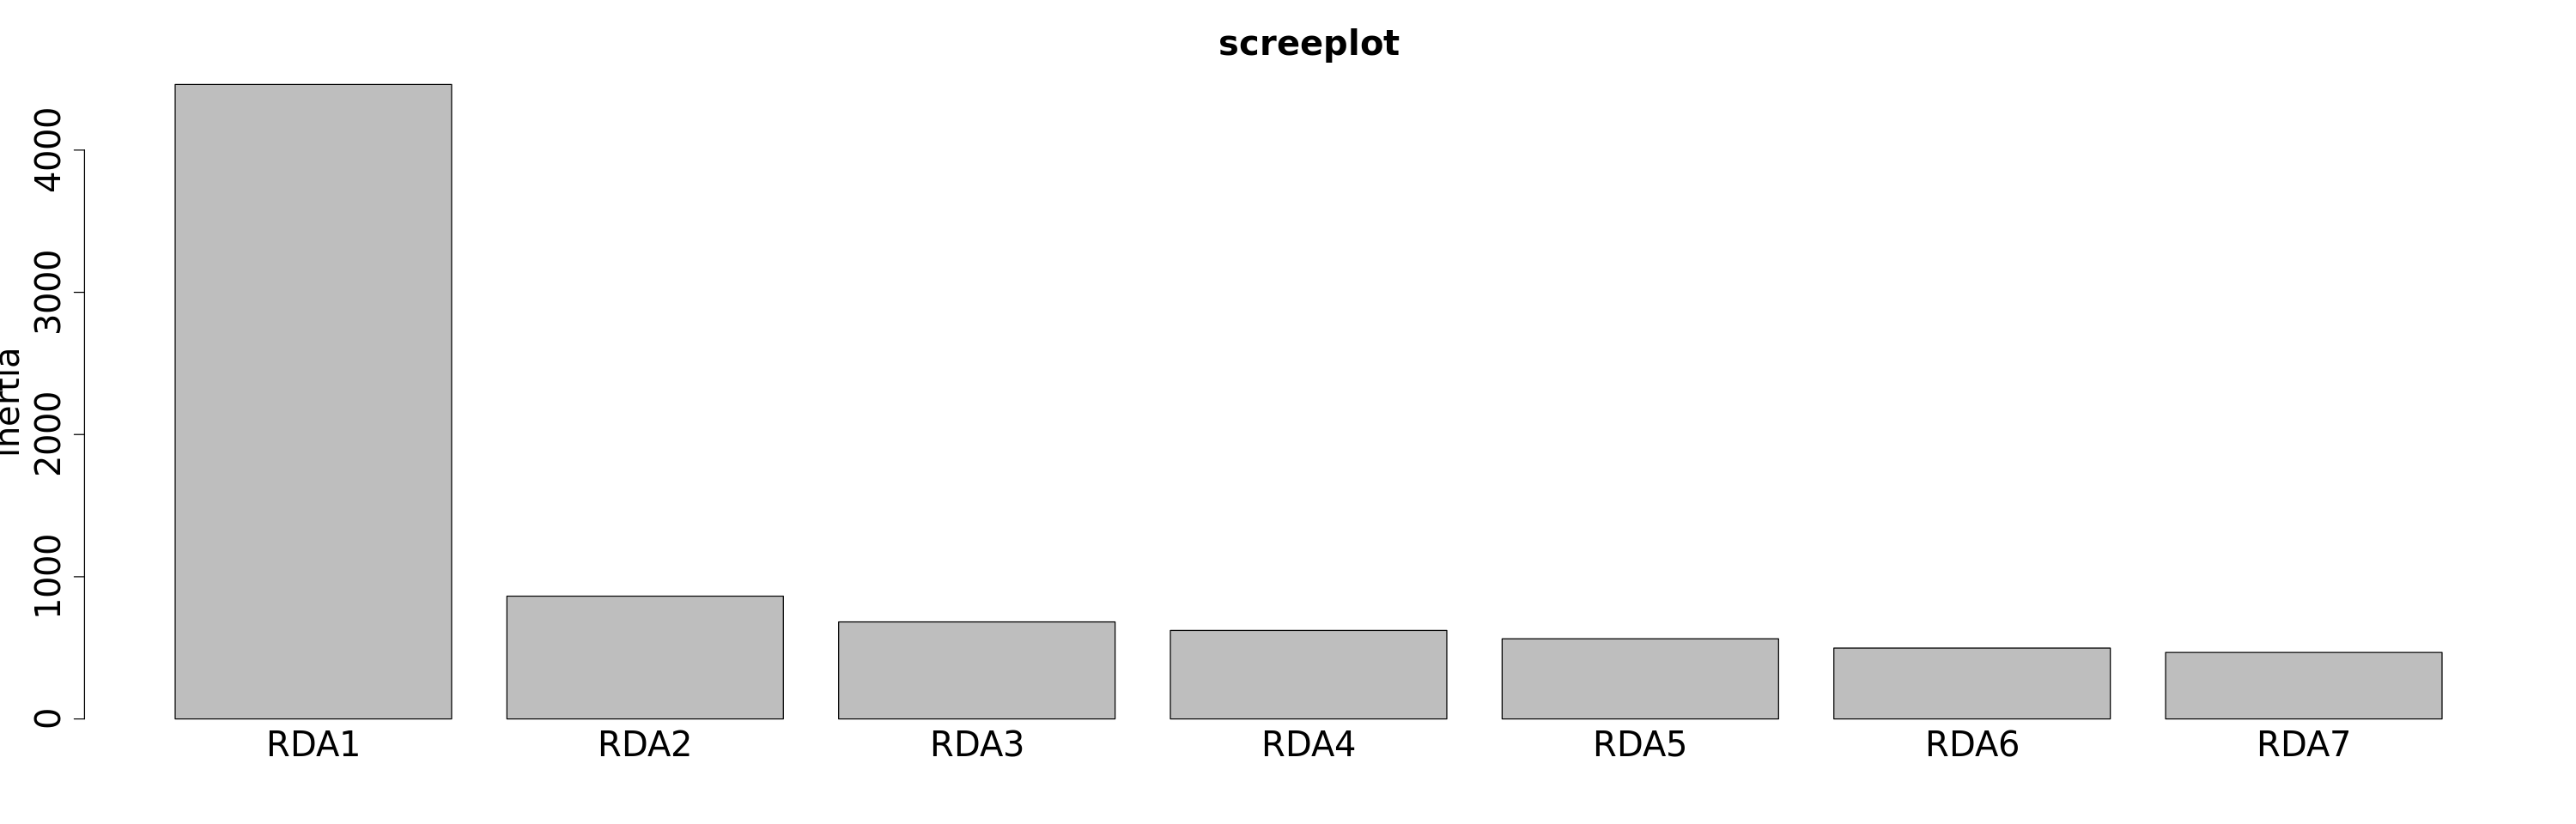

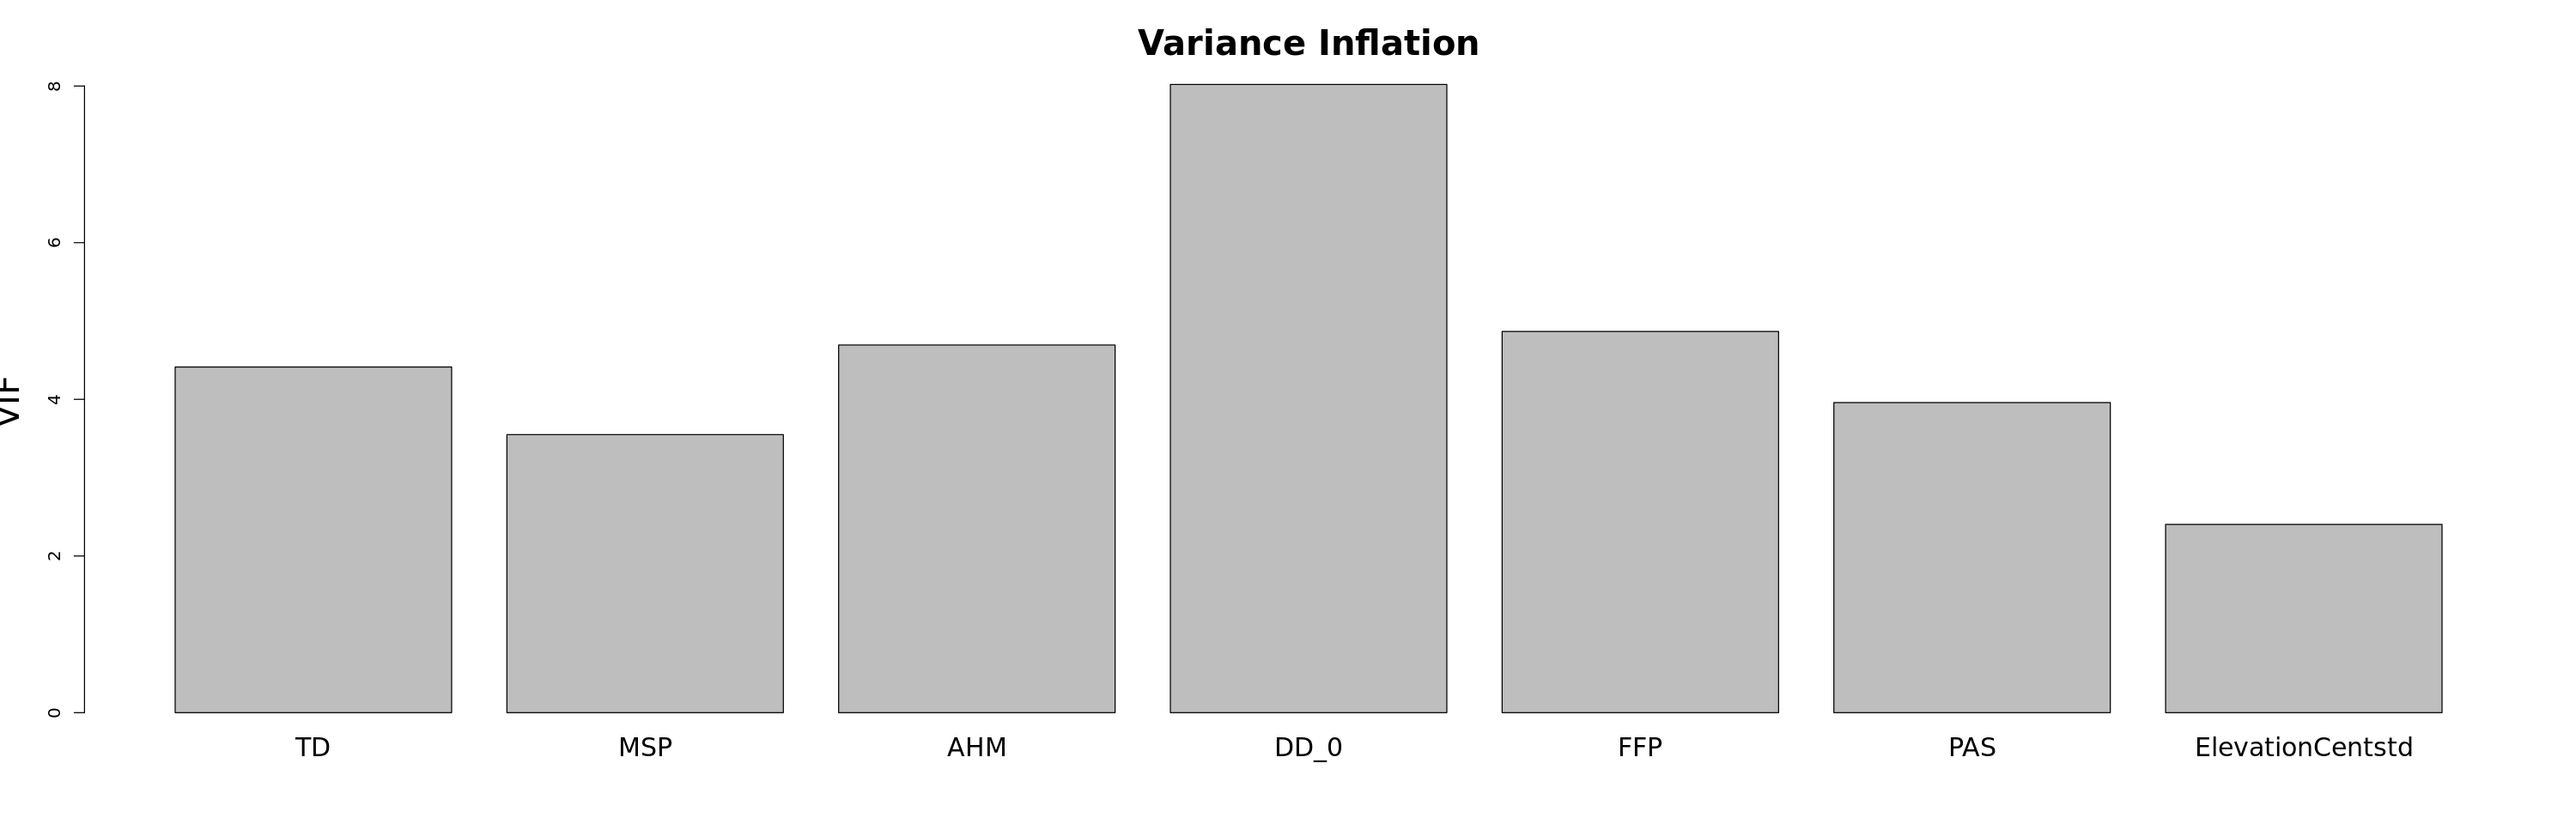

In [21]:
# pick env variables to reduce inflation factors

# look at the envs Sally thought were most important
exclude = c('MWMT', 'DD5', 'NFFD', 'bFFP', 'eFFP', 'EMT', 'EXT', 'Eref', 'CMD',
            'MCMT', 'MAT', 'MAP', 'SHM') # this second line I had to do to reduce VIF

envdata <- prep_envdata(env_file, pops, plot=FALSE, exclude=exclude)

interior_rda <- prep_rda(snps_imp, envstd)

In [22]:
max(vif.cca(interior_rda))

[1] 8.0198754032785330992

In [23]:
vif.cca(interior_rda)

TD                   MSP                   AHM 
4.4126696496739494791 3.5498607869954788008 4.6938924154746484163 
                 DD_0                   FFP                   PAS 
8.0198754032785330992 4.8666131181153149399 3.9585879775430496963 
     ElevationCentstd 
2.4030738485352776124

In [24]:
avg_cors(names(vif.cca(interior_rda)))

,avg
,<dbl>
DD_0,0.958473924269307553381
FFP,0.542333622970307960287
MSP,0.440574800396340060527
AHM,0.225890796484771810837
TD,0.120208711666574347143
ElevationCentstd,0.102353564937357283116
PAS,0.032555377155838241543


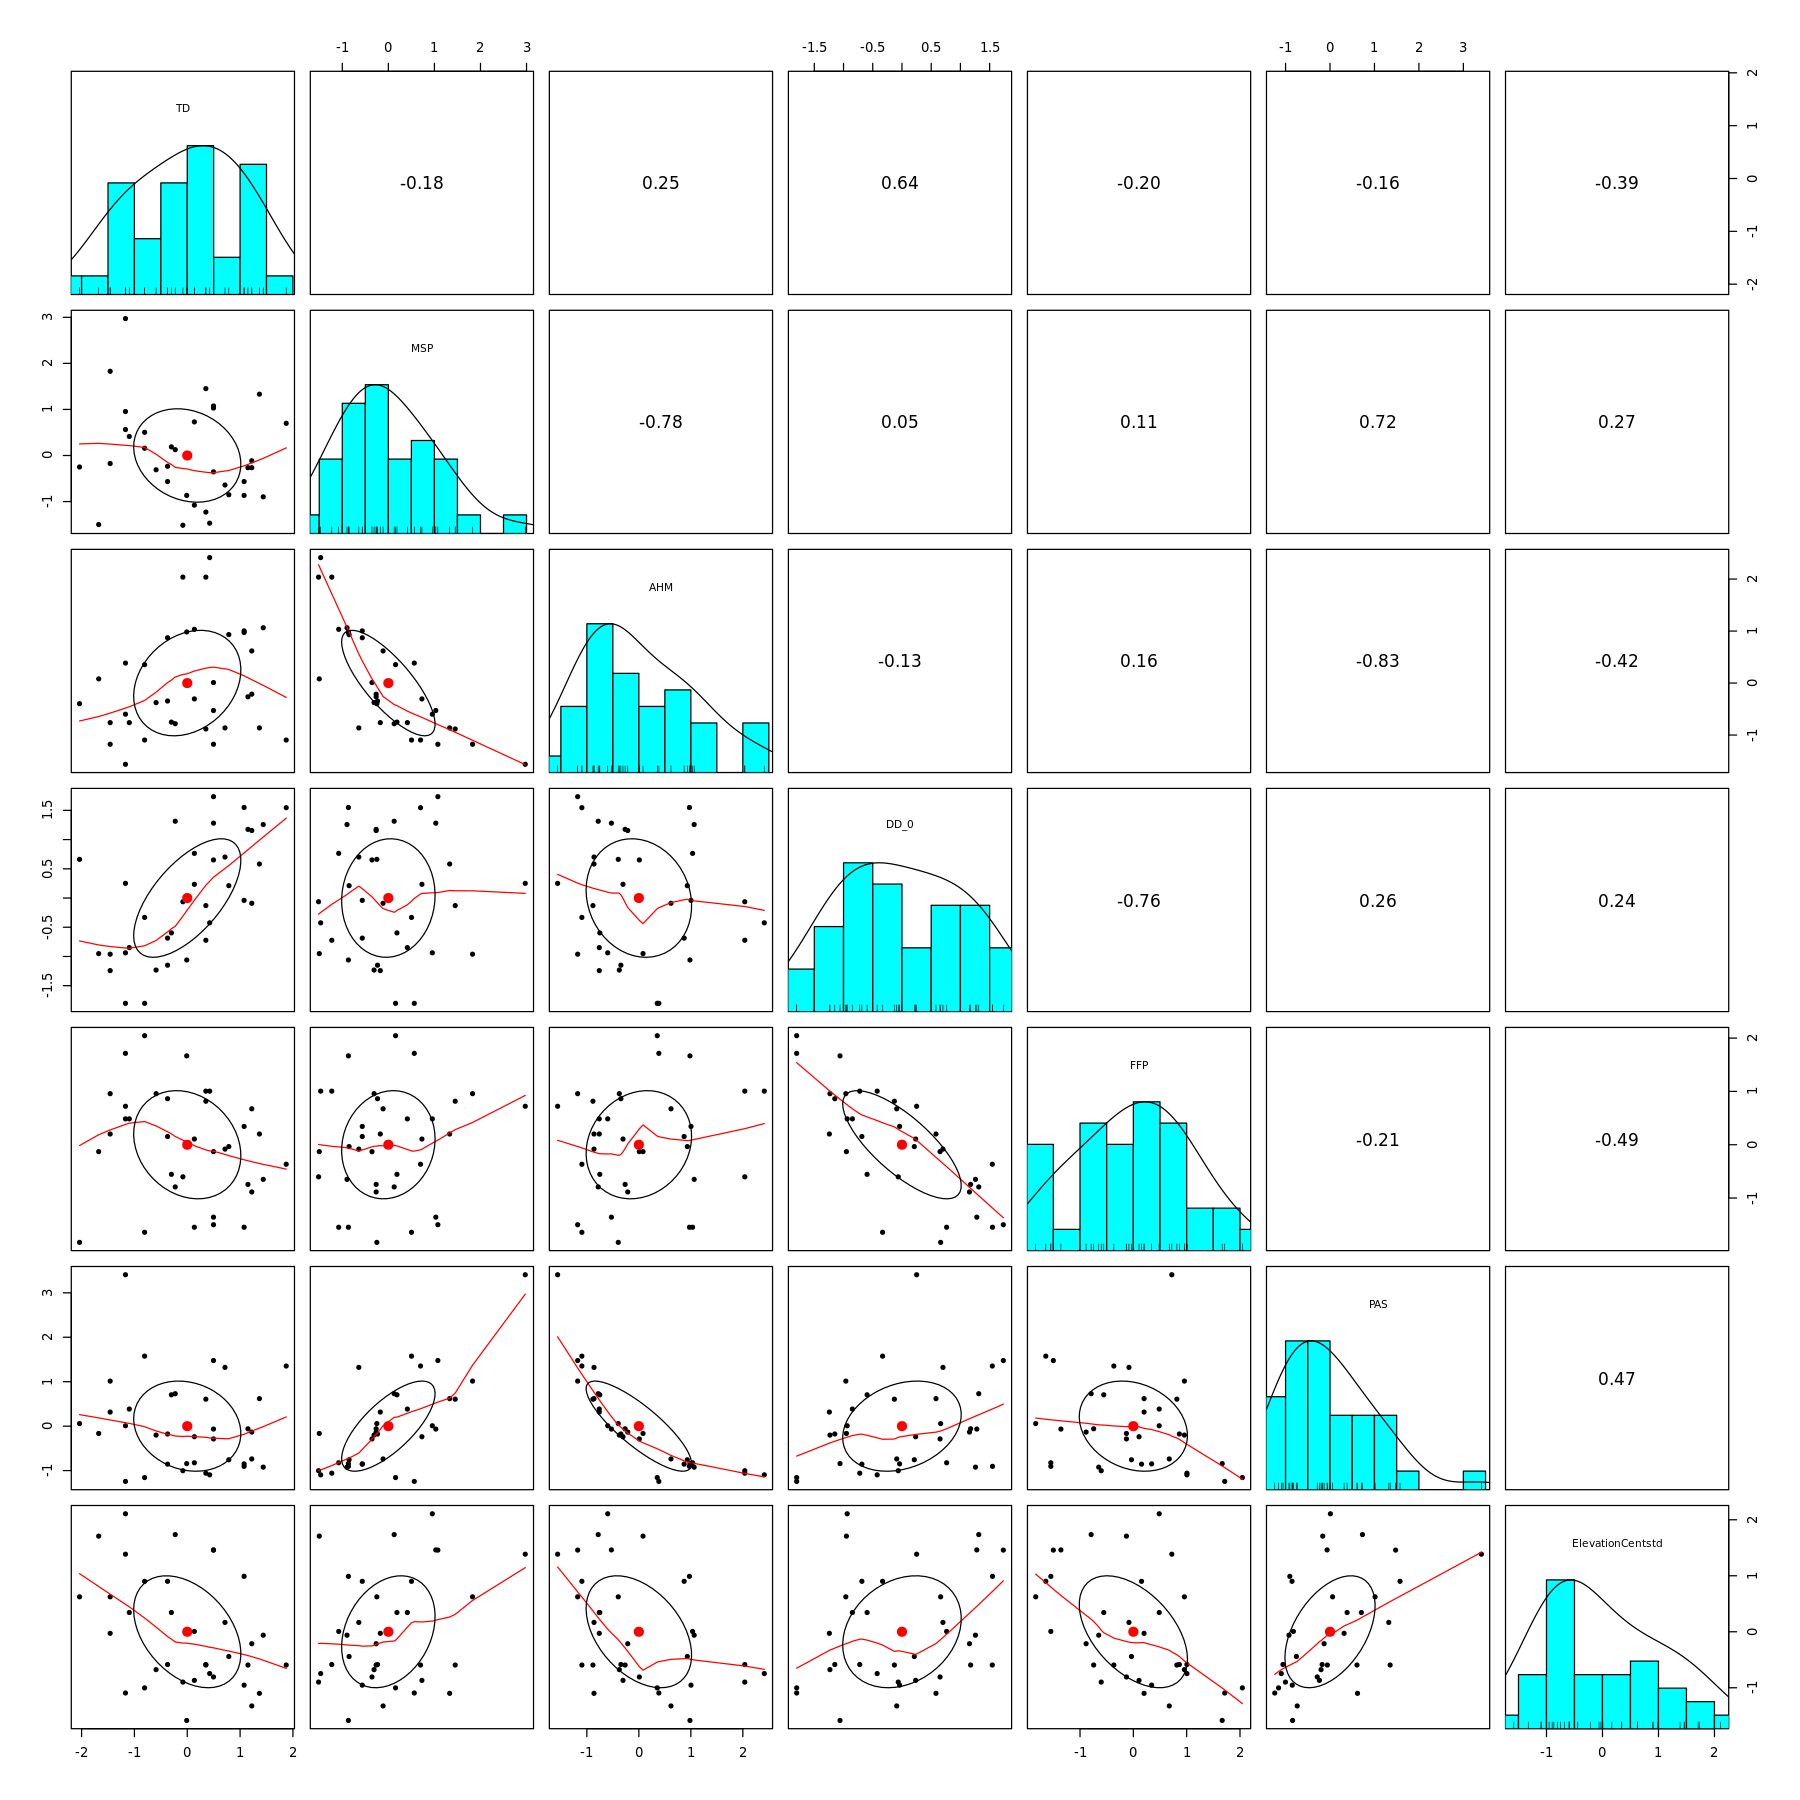

In [25]:
options(repr.plot.width=15, repr.plot.height=15)
pairs.panels(envdata[,names(vif.cca(interior_rda))], scale=F)

In [26]:
rdadir

[1] "/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda"

In [27]:
# save RDA file
saveRDS(interior_rda, rda_file)

In [29]:
# save excluded envs
saveRDS(exclude, exclude_file)

# calculate significance

In [ ]:
# restart notebook to clear mem

#### overall significance

In [ ]:
print('loading rda ...')
interior_rda <- readRDS(paste(rdadir, 'interior_rda_imputed.RDS', sep='/'))

In [ ]:
print('parallelizing permutations ...')
signif.full <- anova.cca(interior_rda, parallel=10) # default is permutation=999

print('writing to file ...')
saveRDS(signif.full, signif_file)

In [ ]:
signif.full

In [ ]:
summary(signif.full)

In [ ]:
print(signif.full)

#### significant axes

```R
# execute in tmux
library(vegan)
rdadir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda'

interior_rda <- readRDS(paste(rdadir, 'interior_rda_imputed.RDS', sep='/'))

signif.axis <- anova.cca(interior_rda, by='axis', parallel=20, nperm=how(nperm=99)

signif_axis_file = paste(rdadir, 'interior_rda_imputed-signif_axis_nperm99.RDS', sep='/')
saveRDS(signif.axis, signif_axis_file)
signif.axis
```

# Identify candidate SNPs involved in local adaptation

In [ ]:
# restart notebook

In [3]:
.get_corr <- function(locus){
    #----------------------------------------------------#
    # GET CORRELATION BETWEEN LOCUS AND ALL ENVIRONMENTS #
    #
    # Returns
    # -------
    # locus name with correlation for each environment
    # ... (tab separated)
    #----------------------------------------------------#
    freq <- snps[,locus]
    line <- paste(locus, paste(as.character(as.vector(apply(.envstd,2,function(x) cor(x,freq)))),collapse='\t'),
                  sep='\t')
    return(line)
}


.timelog <- function(){
    #----------------------------#
    # GET MILLISECOND TIME STAMP #
    #
    # Returns
    # -------
    # eg 08:01:01.001
    #----------------------------#
    options(digits.secs = 3)
    return (strsplit(as.character(Sys.time()), ' ')[[1]][2])
}

                                                      
get_candidates <- function(.rda, outpath, snps, .envstd=envstd, axes=c(1,2), z=2.5, engines=20){
    #------------------------------------------------------------------------#
    # GET CANDIDATE LOCI FROM RDA BASED ON Z-SCORE.
    #
    # Parameters
    # ----------
    # .rda - rda object output by vegan::rda()
    # outpath - where to save the candidate correlations
    # snps - FREQUENCYxPOP table from prep_snps()
    # .envstd - scaled environmental variables
    # axes - the list of significant axes from which to grab candidates
    # z - the z-score threshold by which to identify candidates for each axis
    # engines - the number of library(snow) engines to launch
    #------------------------------------------------------------------------#

    # Species (SNP) scores for the first 2 constrained axes
    load.rda <- scores(.rda, choices=axes, display="species")
    
    # plot hists
    #hist(load.rda[,1], main="Loadings on RDA1")
    #hist(load.rda[,2], main="Loadings on RDA2")
    
    # center/scale loadings so I can choose outliers manually later
    scaled.loadings <- scale(load.rda)
    for (i in 1:ncol(scaled.loadings)){
        colnames(scaled.loadings)[i] <- sprintf('RDA%s_zscore', i)
    }
    # colnames(scaled.loadings) <- c('RDA1_zscore', 'RDA2_zscore')
    
    # combine axis-loading scores and their z-scores
    load.rda <- cbind(load.rda, scaled.loadings)
    
    # combine candidate SNP names
    cands = list()
    ncand = 0
    for (axis in axes){
        message(sprintf('%s : Getting candidates from axis %s ...', .timelog(), axis))
        # set label names to grab data from load.rda table
        rda_label = sprintf('RDA%s', axis)
        z_label = sprintf('%s_zscore', rda_label)
        # grab axis candidates (based on z-score) along with their RDA axis score
        # axis_cands = load.rda[,rda_label] [abs(load.rda[,z_label]) >= z]
        axis_cands = data.frame(load.rda[abs(load.rda[,z_label]) >= z ,c(rda_label, z_label)])
        axis_cands[,'axis'] <- axis
        colnames(axis_cands) <- c('RDA_score', 'RDA_zscore', 'axis')
        # add axis candidates to full candidate list
        cands[[len(cands)+1]] <- axis_cands
        # count total candidates
        # ncand = ncand + len(axis_cands)
        ncand = ncand + nrow(axis_cands)
    }
    message(sprintf('%s : Found %s candidate loci ...', .timelog(), ncand))
    
    # create a dataframe for candidates on each axis
    dfs = list()
    for (axis in axes){
        message(sprintf('%s : Creating candidate dataframe for axis %s ...', .timelog(), axis))
        df <- cands[[axis]]
        df[,'snp'] <- rownames(df)
        dfs[[len(dfs)+1]] <- df
    }
    
    # combine all of the axis candidate dataframes
    cand <- dplyr::bind_rows(dfs)
    cand$snp <- as.character(cand$snp)
    
    # add in the correlations of each candidate SNP with the environmental predictors
    message(sprintf('%s : Starting up cluster with %s engines ...', .timelog(), as.character(engines)))
    cl = makeSOCKcluster(engines)
    # export data to cluster
    message(sprintf('%s : Sending snps and envstd objects to engines ...', .timelog()))
    exports = c('snps', '.envstd')
    clusterExport(cl, exports, envir=environment())
    # get correlation for each locus for each env in parallel
    message(sprintf('%s : Running correlations in parallel ...', .timelog()))
    loci <- as.array(cand[,'snp'])
    out <- parApply(cl, loci, 1, .get_corr)
    # collapse all lines by new line ending
    message(sprintf('%s : Gathering results from engines ...', .timelog()))
    lines <- paste(out, collapse='\n')
    # write colnames and rows, stop cluster
    message(sprintf('%s : Writing results to outfile: %s', .timelog(), outpath))
    columns <- paste(paste('locus', paste(colnames(envstd), collapse='\t'),sep='\t'), '\n', sep='')
    write(columns, file=outpath)
    write(lines, file=outpath)
    stopCluster(cl)

    # read in the correlations, combine with candidate dataframe
    message(sprintf('%s : Reading in outfile ...', .timelog()))
    cors <- fread(outpath, header=F, sep='\t')
    colnames(cors) <- c('locus', colnames(.envstd))
    cand <- cbind.data.frame(cand, cors)

    return(cand)
}

#### imputed

In [4]:
# reload RDA
interior_rda <- readRDS(rda_file)

In [5]:
# load frequency data
snps_imp <- prep_snps(snp_file)
pops <- rownames(snps_imp)
len(pops)

[1] 35

In [6]:
# reload environmental data
exclude = readRDS(exclude_file)
envdata <- prep_envdata(env_file, pops, plot=FALSE, exclude=exclude)

There are 7 environmental attributes in the envdata table.

In [7]:
ptm <- proc.time()  # see how long it takes
interior.cand <- get_candidates(interior_rda, axes=c(1),
                                tmp_candidate_file,
                                snps_imp)
print(proc.time() - ptm)

03:28:02.121 : Getting candidates from axis 1 ...

03:28:02.237 : Found 65531 candidate loci ...

03:28:02.240 : Creating candidate dataframe for axis 1 ...

03:28:02.590 : Starting up cluster with 20 engines ...

03:28:14.113 : Sending snps and envstd objects to engines ...

03:30:53.126 : Running correlations in parallel ...

03:33:31.108 : Gathering results from engines ...

03:33:31.203 : Writing results to outfile: /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda/interior_candidates.txt

03:33:31.241 : Reading in outfile ...



                  user                 system                elapsed 
 31.947000000000006281  23.817000000000000171 330.107000000000084583 


In [8]:
head(interior.cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MSP,AHM,DD_0,FFP,PAS,ElevationCentstd
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
jcf7190000000008-157892,-0.026208616564008052618,-3.0381955240192235479,1,jcf7190000000008-157892,jcf7190000000008-157892,-0.34114661934978102176,0.0566107176740157022610,-0.188140171050642013295,-0.369887226575454974853,0.1680191923062250014542,0.199142110999907001601,0.34804580045212701878
jcf7190000000008-430244,0.017024881831220750605,2.5593586246952106933,1,jcf7190000000008-430244,jcf7190000000008-430244,0.37409560556017101840,-0.0094326190994335392531,-0.044767836557458501323,0.435501814922019003795,-0.3105747563292929891432,-0.023177006466763201004,-0.29407870092479698743
jcf7190000000014-6890,-0.022979227193073492597,-2.6200780331366453346,1,jcf7190000000014-6890,jcf7190000000014-6890,-0.39721221117223198815,-0.0045290111240668803547,-0.097852965359601001838,-0.425718094262653001802,0.1619402350561509884574,-0.052574729259802402415,0.27609853586193700004
jcf7190000000014-15050,-0.044357640542784251836,-5.3879971417094507657,1,jcf7190000000014-15050,jcf7190000000014-15050,-0.14674084607596898921,0.3614994664097950227699,-0.513364155109386044451,-0.046306459152124002099,0.0103524550352873997289,0.374187451878196020161,0.44890505650744599864
jcf7190000000014-15158,-0.047313460405202491244,-5.7706948725865263583,1,jcf7190000000014-15158,jcf7190000000014-15158,-0.16318829957514599527,0.3354206506574670121346,-0.499019776218202981699,-0.052954103717632601545,0.0026038677431585999233,0.372008268392119978429,0.47127322020036099826
jcf7190000000022-98776,0.017713061723464866570,2.6484590758240513786,1,jcf7190000000022-98776,jcf7190000000022-98776,0.20259120271473898822,-0.2539988791359509834322,0.389792123105411003614,0.194806116713406002328,-0.0984162754504593062510,-0.340382306657698974206,-0.31514830513961400449


In [9]:
# make sure locus labels are correct to ensure they didn't get shuffled during parallelization
all(interior.cand[,'snp'] == interior.cand[,'locus'])

[1] TRUE

# investigate the candidates

In [10]:
# how many unique candidates
len(uni(interior.cand$snp))

[1] 65531

##### handle duplicates - keep the duplicate with the highest axis loading

in the example, they exclude markers that are duplicated across axes, I'm not going to do that.

In [11]:
# how many rows (includes duplicates)
nrow(interior.cand)

[1] 65531

In [12]:
# how many are duplicated
sum(duplicated(interior.cand$snp))

[1] 0

In [13]:
foo <- cbind(interior.cand$axis, duplicated(interior.cand$snp)) 
table(foo[foo[,1]==1,2])


    0 
65531 

In [14]:
# all are duplicated on axis 2
table(foo[foo[,1]==2,2])

< table of extent 0 >

In [15]:
head(interior.cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MSP,AHM,DD_0,FFP,PAS,ElevationCentstd
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
jcf7190000000008-157892,-0.026208616564008052618,-3.0381955240192235479,1,jcf7190000000008-157892,jcf7190000000008-157892,-0.34114661934978102176,0.0566107176740157022610,-0.188140171050642013295,-0.369887226575454974853,0.1680191923062250014542,0.199142110999907001601,0.34804580045212701878
jcf7190000000008-430244,0.017024881831220750605,2.5593586246952106933,1,jcf7190000000008-430244,jcf7190000000008-430244,0.37409560556017101840,-0.0094326190994335392531,-0.044767836557458501323,0.435501814922019003795,-0.3105747563292929891432,-0.023177006466763201004,-0.29407870092479698743
jcf7190000000014-6890,-0.022979227193073492597,-2.6200780331366453346,1,jcf7190000000014-6890,jcf7190000000014-6890,-0.39721221117223198815,-0.0045290111240668803547,-0.097852965359601001838,-0.425718094262653001802,0.1619402350561509884574,-0.052574729259802402415,0.27609853586193700004
jcf7190000000014-15050,-0.044357640542784251836,-5.3879971417094507657,1,jcf7190000000014-15050,jcf7190000000014-15050,-0.14674084607596898921,0.3614994664097950227699,-0.513364155109386044451,-0.046306459152124002099,0.0103524550352873997289,0.374187451878196020161,0.44890505650744599864
jcf7190000000014-15158,-0.047313460405202491244,-5.7706948725865263583,1,jcf7190000000014-15158,jcf7190000000014-15158,-0.16318829957514599527,0.3354206506574670121346,-0.499019776218202981699,-0.052954103717632601545,0.0026038677431585999233,0.372008268392119978429,0.47127322020036099826
jcf7190000000022-98776,0.017713061723464866570,2.6484590758240513786,1,jcf7190000000022-98776,jcf7190000000022-98776,0.20259120271473898822,-0.2539988791359509834322,0.389792123105411003614,0.194806116713406002328,-0.0984162754504593062510,-0.340382306657698974206,-0.31514830513961400449


In [16]:
# determine which rows to keep

t = table(interior.cand$snp) # count snps
dups = names(t[t >= 2])  # ID duplicates
# figure out which duplicate to keep - keep the one with highest loading
x = interior.cand[interior.cand$snp %in% dups,]
x = x[rownames(x)[order(x$snp)],]
if (len(dups) > 0){
    keep = c()
    for (snp in dups){
        snpdf = x[x$snp==snp,]
        maxx = 0
        whichrow = 0
        for (row in rownames(snpdf)){
            if (abs(snpdf[row, 'RDA_score']) > maxx){
                maxx = abs(snpdf[row, 'RDA_score'])
                whichrow = row
            }
        }
        keep = c(keep, whichrow)
    }  
    stopifnot(len(keep) == nrow(x)/2)
} else keep = interior.cand$snp
len(keep)

[1] 65531

In [17]:
# filter interior.cand to remove the lower scoring duplicates
if (len(dups) > 0){
    dupdf = interior.cand[keep, ]
    print(nrow(dupdf))
    cand <- interior.cand[!rownames(interior.cand) %in% rownames(x),]  # remove duplicate detections
    print(nrow(cand))
    cand <- rbind(cand, dupdf)  # combine    
} else cand <- interior.cand
rownames(cand) <- 1:range(nrow(cand))  # rename rows
nrow(cand)

Warning message in 1:range(nrow(cand)):
“numerical expression has 2 elements: only the first used”


[1] 65531

#### assign predictors to each outlier locus

In [18]:
rda_envs = colnames(cand)[colnames(cand) %in% colnames(envdata)]
rda_envs

[1] "TD"               "MSP"              "AHM"              "DD_0"            
[5] "FFP"              "PAS"              "ElevationCentstd"

In [19]:
head(cand)

,RDA_score,RDA_zscore,axis,snp,locus,TD,MSP,AHM,DD_0,FFP,PAS,ElevationCentstd
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.026208616564008052618,-3.0381955240192235479,1,jcf7190000000008-157892,jcf7190000000008-157892,-0.34114661934978102176,0.0566107176740157022610,-0.188140171050642013295,-0.369887226575454974853,0.1680191923062250014542,0.199142110999907001601,0.34804580045212701878
2,0.017024881831220750605,2.5593586246952106933,1,jcf7190000000008-430244,jcf7190000000008-430244,0.37409560556017101840,-0.0094326190994335392531,-0.044767836557458501323,0.435501814922019003795,-0.3105747563292929891432,-0.023177006466763201004,-0.29407870092479698743
3,-0.022979227193073492597,-2.6200780331366453346,1,jcf7190000000014-6890,jcf7190000000014-6890,-0.39721221117223198815,-0.0045290111240668803547,-0.097852965359601001838,-0.425718094262653001802,0.1619402350561509884574,-0.052574729259802402415,0.27609853586193700004
4,-0.044357640542784251836,-5.3879971417094507657,1,jcf7190000000014-15050,jcf7190000000014-15050,-0.14674084607596898921,0.3614994664097950227699,-0.513364155109386044451,-0.046306459152124002099,0.0103524550352873997289,0.374187451878196020161,0.44890505650744599864
5,-0.047313460405202491244,-5.7706948725865263583,1,jcf7190000000014-15158,jcf7190000000014-15158,-0.16318829957514599527,0.3354206506574670121346,-0.499019776218202981699,-0.052954103717632601545,0.0026038677431585999233,0.372008268392119978429,0.47127322020036099826
6,0.017713061723464866570,2.6484590758240513786,1,jcf7190000000022-98776,jcf7190000000022-98776,0.20259120271473898822,-0.2539988791359509834322,0.389792123105411003614,0.194806116713406002328,-0.0984162754504593062510,-0.340382306657698974206,-0.31514830513961400449


In [20]:
# see which of the predictors each candidate SNP is most strongly correlated with
# this is reallllyyyyyyy slow .....
rda_envs = colnames(cand)[colnames(cand) %in% colnames(envdata)]
env_col = ncol(cand) + 1
cor_col = env_col + 1
for (i in 1:length(cand$snp)) {
    if (i %% 100 == 0){
        # echo so I don't get a lot of printouts
            # instead I can watch in the terminal window that's running notebook
        system(sprintf('echo %s', as.character(i)))
    }
    bar <- cand[i,]
    cand[i,env_col] <- names(which.max(abs(bar[rda_envs]))) # environmental variable
    cand[i,cor_col] <- max(abs(bar[rda_envs]))                  # correlation
}

colnames(cand)[env_col] <- "predictor"
colnames(cand)[cor_col] <- "correlation"

table(cand$predictor) 


             AHM             DD_0 ElevationCentstd              FFP 
            2038             4320            46643              102 
             MSP              PAS               TD 
             184              129            12115 

In [21]:
nrow(cand)

[1] 65531

In [22]:
uni(cand$axis)

[1] 1

#### plot the snps

In [25]:
.create_fig <- function(.rda, xlim, ylim, revert_col.pred, empty.outline, empty, cols, bg){
    options(repr.plot.width=10, repr.plot.height=10)
    plot(.rda, type="n", scaling=3, xlim=xlim, ylim=ylim)
    points(.rda, display="species", pch=21, cex=1, col="gray32", bg=revert_col.pred, scaling=3)
    points(.rda, display="species", pch=21, cex=1, col=empty.outline, bg=empty, scaling=3)
    text(.rda, scaling=3, display="bp", col="#0868ac", cex=1)
    legend("topright", legend=cols, bty="n",
           col="gray32", pch=21, cex=1, pt.bg=bg)
}

plot_candidates <- function(.rda, z=NA, save=TRUE, xlim=c(-0.15,0.15), ylim=c(-0.15,0.15), figfile=NA, display=TRUE){
    #--------------------------------------------------#
    # +   COLOR CODE OUTLIERS BY BEST PREDICTOR
    # +/- REDUCE OUTLIERS BY AXIS LOADING Z-SCORE
    # +/- PLOT CANDIDATE OUTLIERS ON RDA AXES
    # +/- SAVE PLOTTED FIGURE AS PDF
    #
    # Notes
    # -----
    # - the following are placed into global namespace
    # reorder_col.pred, revert_col.pred, empty.outline,
    # empty
    # 
    #--------------------------------------------------#
    
    # 1) reduce candidate data.frame if z is not NULL
    if (is.na(z)==FALSE){
        # filter for z
        message(sprintf('%s : Reducing candidates to z>=%s ...', .timelog(), z))
        .cand <- cand[abs(cand$RDA_zscore)>=z, ]
    } else {
        message(sprintf('%s : Keeping all candidate snps ...', .timelog()))
        .cand <- cand}  # or just use the default from above (2.5)
    
    # 2) assign colors to environmental variables, in the order they appear in envstd
    message(sprintf('%s : Assinging colors to environments ...', .timelog()))
    rda_envstd <- envstd[, rda_envs]
    env_color <- .cand$predictor  # list of best predictor
    colors <- c('#1f78b4', '#a6cee3', '#6a3d9a', '#e31a1c', '#33a02c', '#ffff33', '#fb9a99', '#b2df8a', 'darkviolet')
    if (len(colors) < len(rda_envs)){
        stop("More colors are needed in the color vector object `color`. There are fewer colors than environmental variables.")
    }
    for (i in 1:ncol(rda_envstd)){
        # replace best predictor with color
        env_color[env_color==colnames(rda_envstd)[i]] <- colors[i]
    }
    # pass to candidate data.frame
    .cand[,'env_color'] <- env_color
    rownames(.cand) <- .cand$snp
    
    # 3) color code candidate SNPs - their way took waaaay too long!
        # their way:
        # print('iterating sel ...')
        # for (i in 1:length(sel)) { # color code candidate SNPs
        #     foo <- match(sel[i],col.pred)
        #     col.pred[foo] <- env_color[i]
        # }
    # my way:
    # 3.1) identify SNP sets
    message(sprintf('%s : Assinging colors to SNPs ...', .timelog()))
    sel <- .cand$snp  # identify candidate SNPs (subset)
    col.pred <- rownames(.rda$CCA$v) # identify all SNPs (including candidates) (full set)
    print(c(len(sel), len(col.pred)))
    
    # 3.2) reorder col.pred in the same order as sel, the end of the col.pred list will be the loci not in sel
    reorder_col.pred <<- col.pred[order(match(col.pred, sel))]
    
    # 3.3) do checks
    #stopifnot(all(head(sel)[1:5]==reorder_col.pred[1:5]))  # are the first 5 the same? A: yes!
    stopifnot(suppressWarnings(sum(reorder_col.pred==sel) == len(sel))) # the first len(sel) match, which is what we want (warning about lengths)

    # 3.4) make sure all of sel is at the top of reorder_col.pred
    bools = reorder_col.pred %in% sel
    stopifnot(sum(bools[1:len(sel)])==len(sel))  # are the `sel` loci at the top of the list? A: yes!
    stopifnot(sum(bools[(len(sel)+1):len(bools)])==0)  # are the other loci not in sel? A: yes!
    
    # 3.5) color col.pred like they did (I can do this because loci are now in same order as env_color ie cand dataframe)
    reorder_copy <- reorder_col.pred  # make a copy so I can assert order is correct by using loci names below
    reorder_col.pred[1:len(sel)] <- env_color  # overwrite outlier loci names with outlier colors
    
    # 3.6) reorder loci names to match the output from the RDA object - use this to verify order below
    revert_copy <- reorder_copy[order(match(reorder_copy, col.pred))]
    
    # 3.7) now revert the color vector to the order found in the RDA object 
        # note I'm still using reorder_copy (ie all loci names) to reorder
    revert_col.pred <<- reorder_col.pred[order(match(reorder_copy, col.pred))]
    
    # 3.8) assert loci names are in the same order (this asserts that the color order is correct)
    stopifnot(all(revert_copy==col.pred))
    
    # 3.9) color the non-candidate loci gray
    # get non-candidate SNPs by grepping a hyphen that separates CHROM and POS in the SNP name
    revert_col.pred[grep("-", revert_col.pred)] <- '#f1eef6'
    empty <<- revert_col.pred
    empty[grep("#f1eef6", empty)] <- rgb(0,1,0, alpha=0) # transparent
    empty.outline <<- ifelse(empty=="#00FF0000","#00FF0000","gray32")
    #bg = colors
    
    # 3.10) print counts for each color/env
    print(table(revert_col.pred))
    
    # 4) plot +/- save
    if (save==TRUE){
        # save outlier fig
        message(sprintf('%s : Saving figure to \n\t%s ...', .timelog(), figfile))
        pdf(paste(figfile))
        .create_fig(.rda, xlim, ylim, revert_col.pred, empty.outline, empty, colnames(rda_envstd), colors)
        dev.off()
    }
    if (display==TRUE){
        message(sprintf('%s : Generating figure display ...', .timelog()))
        .create_fig(.rda, xlim, ylim, revert_col.pred, empty.outline, empty, colnames(rda_envstd), colors)  # display for notebook
    }

    # 5) return color-coded candidate file
    return (.cand)
    
}

03:39:19.121 : Reducing candidates to z>=4 ...

03:39:19.127 : Assinging colors to environments ...

03:39:19.131 : Assinging colors to SNPs ...



[1]    5734 2483660
revert_col.pred
#1f78b4 #33a02c #6a3d9a #a6cee3 #e31a1c #f1eef6 #fb9a99 
    585       3    1131       4      89 2477926    3922 


03:39:22.696 : Generating figure display ...



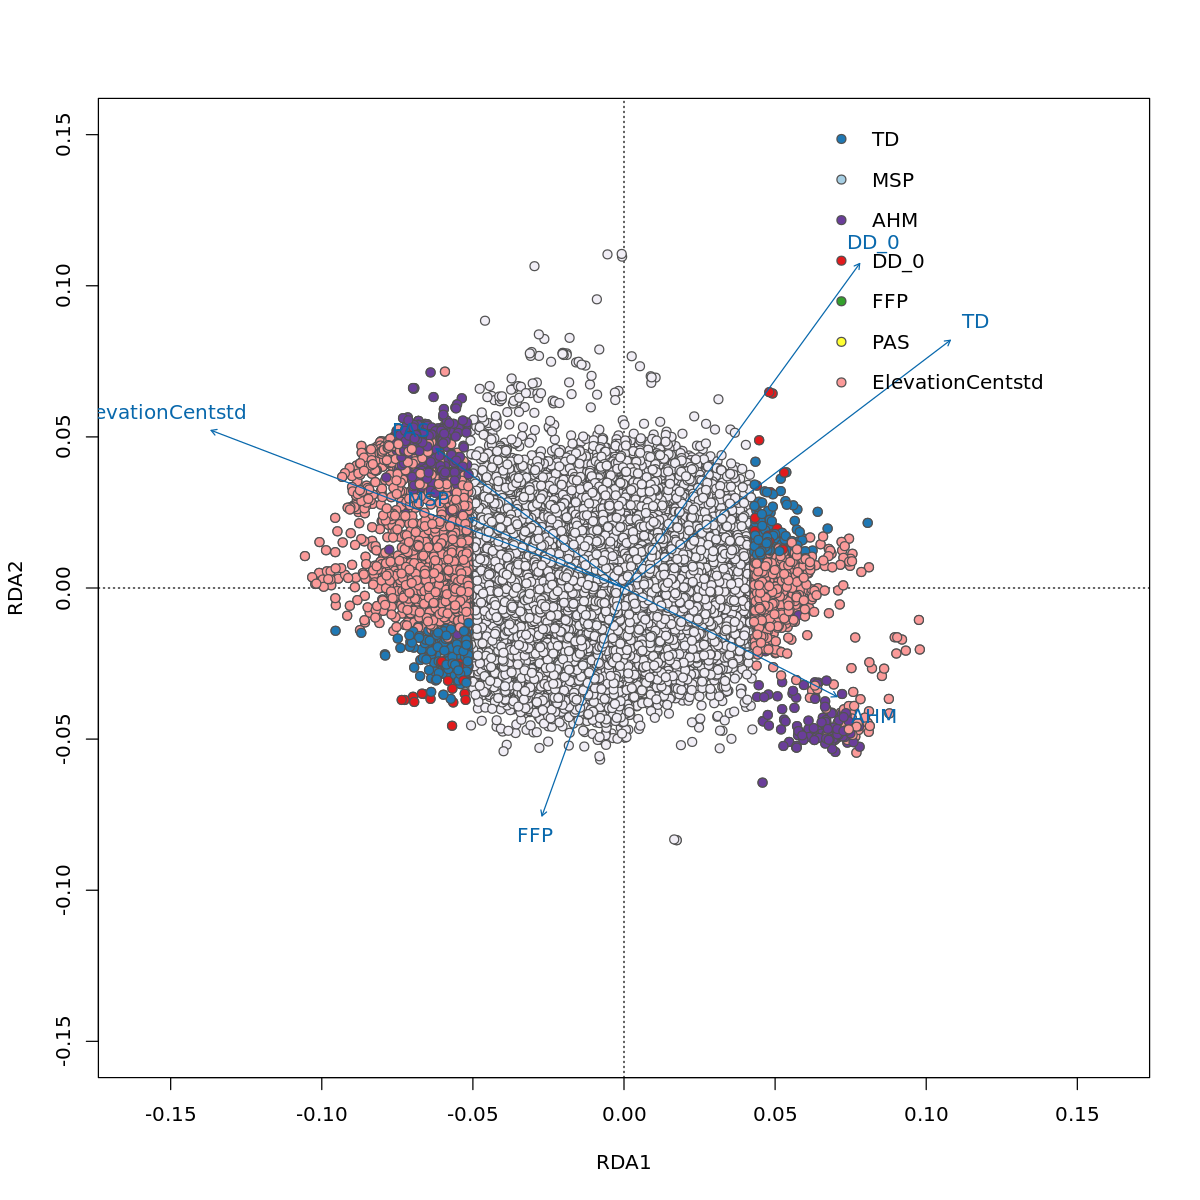

In [26]:
z4.cand <- plot_candidates(interior_rda, save=FALSE, z=4)

In [27]:
# interior
table(z4.cand$predictor)


             AHM             DD_0 ElevationCentstd              FFP 
            1131               89             3922                3 
             MSP               TD 
               4              585 

03:41:06.382 : Keeping all candidate snps ...

03:41:06.385 : Assinging colors to environments ...

03:41:06.417 : Assinging colors to SNPs ...



[1]   65531 2483660
revert_col.pred
#1f78b4 #33a02c #6a3d9a #a6cee3 #e31a1c #f1eef6 #fb9a99 #ffff33 
  12115     102    2038     184    4320 2418129   46643     129 


03:41:11.172 : Saving figure to 
	/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/rda/RDA_coastal_9-vars_ax1-2_outliers-z2p5.pdf ...

03:42:40.495 : Generating figure display ...



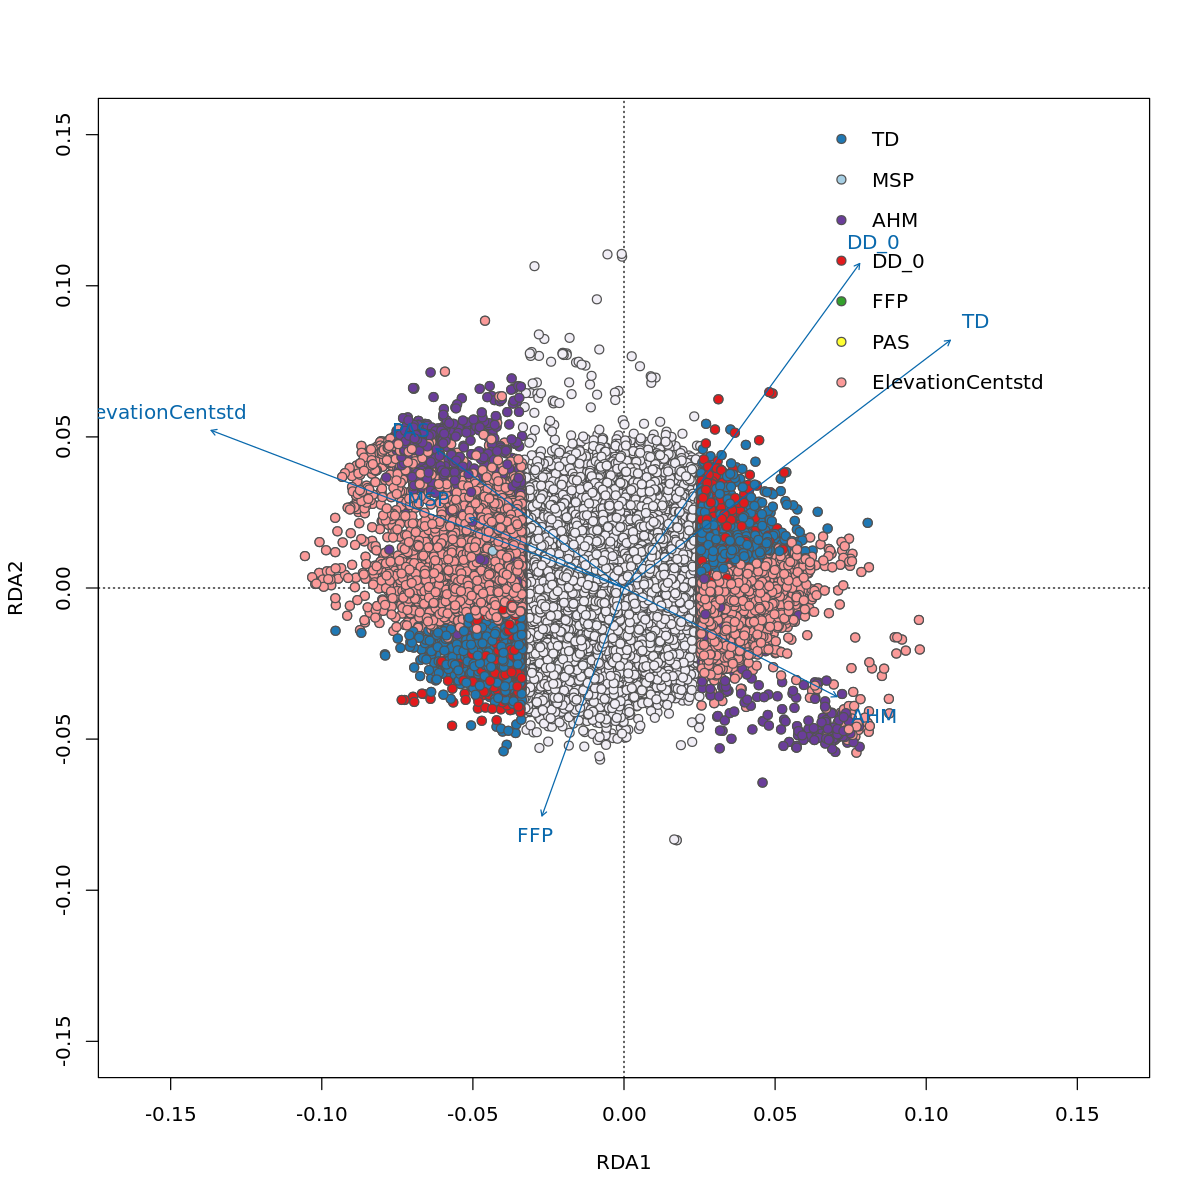

In [28]:
# plot all outliers (z>=2.5)
# use output from plot_candidates below to save info for all feasible outliers
figfile = paste(rdadir, 'RDA_coastal_9-vars_ax1-2_outliers-z2p5.pdf', sep='/')
.cand <- plot_candidates(interior_rda, figfile=figfile)

In [29]:
table(.cand$predictor)


             AHM             DD_0 ElevationCentstd              FFP 
            2038             4320            46643              102 
             MSP              PAS               TD 
             184              129            12115 

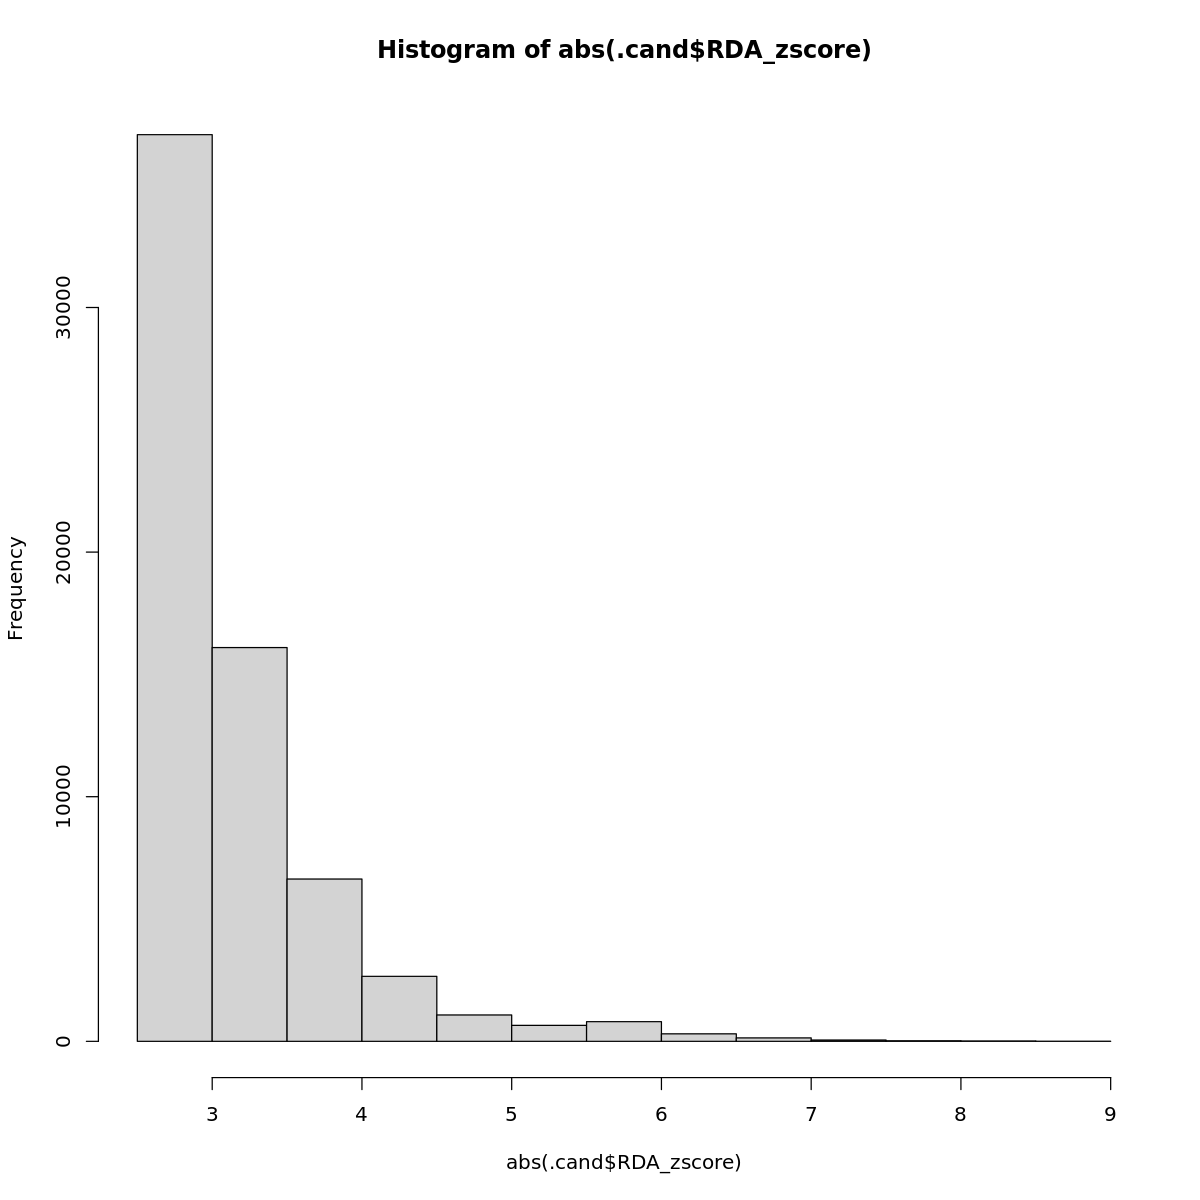

In [30]:
hist(abs(.cand$RDA_zscore))

In [31]:
saveRDS(reorder_col.pred, paste(rdadir, 'reorder_col.pred.RDS', sep='/'))
saveRDS(revert_col.pred, paste(rdadir, 'revert_col.pred.RDS', sep='/'))
saveRDS(empty.outline, paste(rdadir, 'empty.outline.RDS', sep='/'))
saveRDS(empty, paste(rdadir, 'empty.RDS', sep='/'))

In [32]:
write.table(.cand, candidate_file, sep='\t', row.names=F)

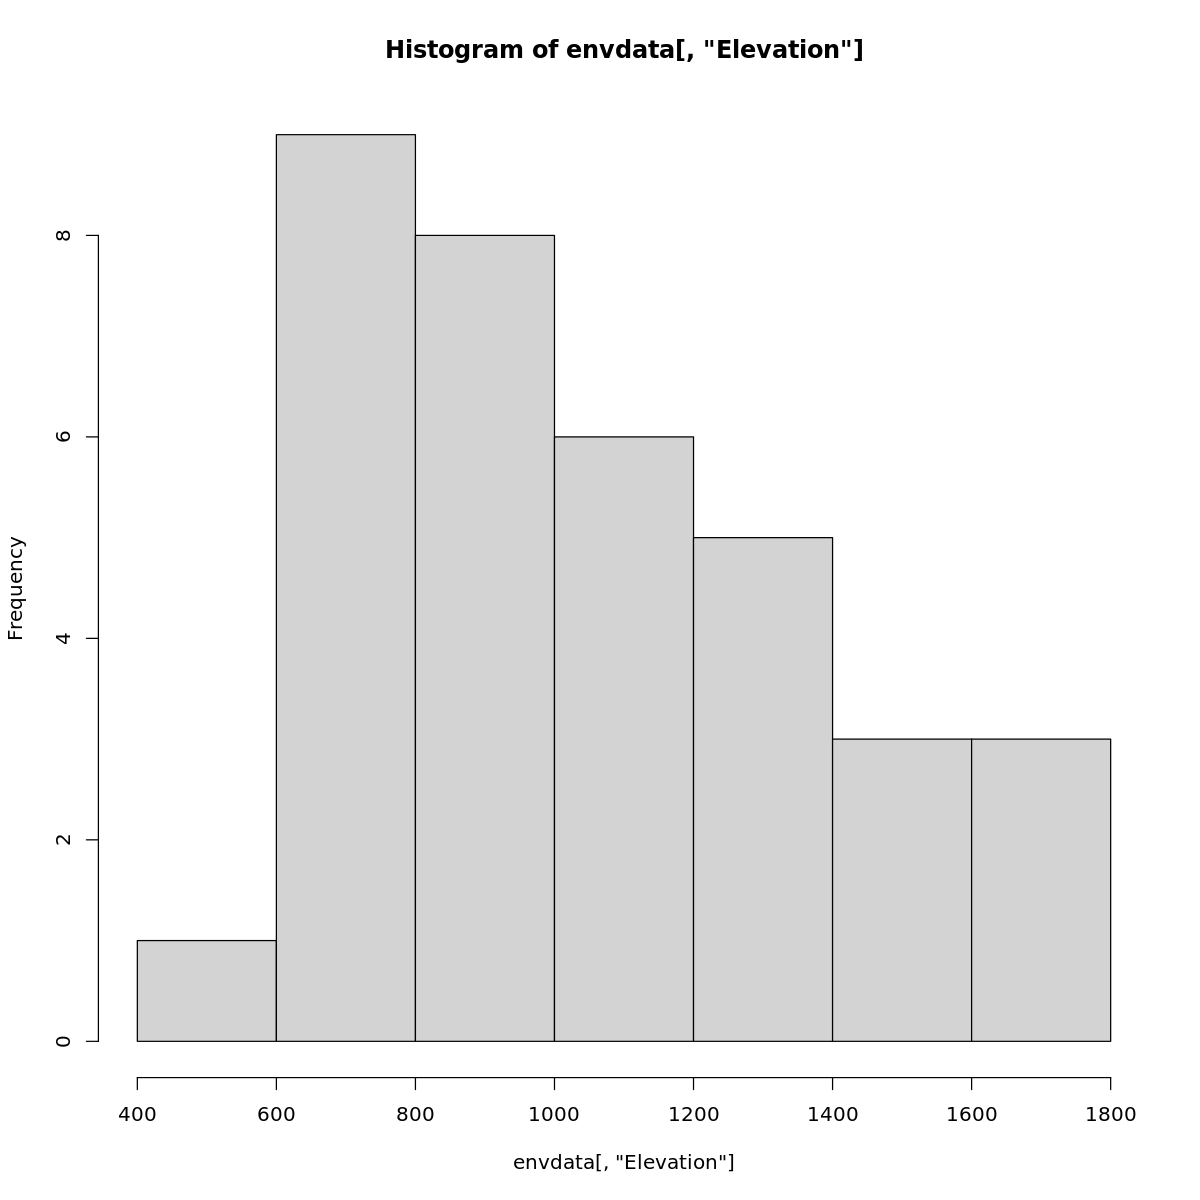

In [33]:
hist(envdata[,'Elevation'])

In [34]:
max(envdata[,'Elevation'])

[1] 1737

In [20]:
range(envdata[,'Elevation'])

[1]  525 1737